# LendingClub Loan Data Prediction (EDA and Model Building)

*By Aayush Kumar*

## Table of Contents

* [1. Introduction and Objectives](#1)
* [2. Basic Libraries and File Imports](#2)
* [3. Data Cleaning](#3)
* [4. Preprocessing, Exploratory Analysis and Feature Engineering](#4)
 * [4.1 addr_state](#4.1)
 * [4.2 annual_inc](#4.2)
 * [4.3 earliest_cr_line](#4.3)
 * [4.4 emp_length](#4.4)
 * [4.5 emp_title](#4.5)
 * [4.6 fico_range_high and fico_range_low](#4.6)
 * [4.7 grade and sub_grade](#4.7)
 * [4.8 home_ownership](#4.8)
 * [4.9 application_type](#4.9)
 * [4.10 initial_list_status](#4.10)
 * [4.11 int_rate](#4.11)
 * [4.12 loan_amnt](#4.12)
 * [4.13 num_actv_bc_tl](#4.13)
 * [4.14 mort_acc](#4.14)
 * [4.15 total_acc](#4.15)
 * [4.16 tot_cur_bal](#4.16)
 * [4.17 open_acc](#4.17)
 * [4.18 pub_rec](#4.18)
 * [4.19 pub_rec_bankruptcies](#4.19)
 * [4.20 purpose](#4.20)
 * [4.21 term](#4.21)
 * [4.22 title](#4.22)
 * [4.23 revol_bal](#4.23)
 * [4.24 revol_util](#4.24)
 * [4.25 verification_status](#4.25)
* [5. Scaling and Test Train split](#5)
* [6. Creating Models](#6)
 * [6.1 XGBoost](#6.1)
 * [6.2 Random Forests](#6.2)
 * [6.3 ANN](#6.3)
* [7. Conclusion](#7)

# 1. Introduction and Objectives
<a id="1"></a>

### Introduction

LendingClub is is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. According to Wikipedia,
> LendingClub is a peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. At its height, LendingClub was the world's largest peer-to-peer lending platform. The company claims that 15.98 billion in loans had been originated through its platform up to December 31, 2015. LendingClub enabled borrowers to create unsecured personal loans between 1,000 dollars and 40,000 dolars. The standard loan period was three years. Investors were able to search and browse the loan listings on LendingClub website and select loans that they wanted to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors made money from the interest on these loans. LendingClub made money by charging borrowers an origination fee and investors a service fee.

### Objectives

The aim of this project is to predict the chance that a loan will charge off, i.e., the customers who are not able to pay back the loan amount. Since customers who don't pay back their loan amount are a source of loss for the company, we want to build a model which predicts if a particular applicant will or will not be able to payback the loan amount. We are going to act as a data scientist for LendingClub for this particular project and try to search for potential solution for their problem. Ofcourse some domain knowledge is required but we will be skipping those features that are outside our understanding. Without further ado, let's directly jump onto solving the challenge!

# 2. Basic Libraries and File Imports
<a id="2"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

Check available files.

In [3]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

We will read the 'accepted_2007_to_2018Q4' data file from which we will source the necessary data.

In [4]:
# Add low_memory=False if there are RAM limitations
# df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv",low_memory=False) # takes some time because of the length of file
df = pd.read_csv("accepted_2007_to_2018Q4.csv",low_memory=False) # takes some time because of the length of file

In [5]:
# df.head()

In [6]:
len(df)

130770

In [7]:
# We want to predict if a particular loan was fully paid or charged off (if it was paid or the customer was not able to pay back the loan amount)
df['loan_status'].value_counts()

Fully Paid            92209
Charged Off           22898
Current               14787
Late (31-120 days)      537
In Grace Period         236
Late (16-30 days)       102
Default                   1
Name: loan_status, dtype: int64

In [8]:
# We will drop rows which have loan_status other than Fully Paid and Charged Off
df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [9]:
# check number of df after dropping rows. it was 2260701 initially
len(df)

115107

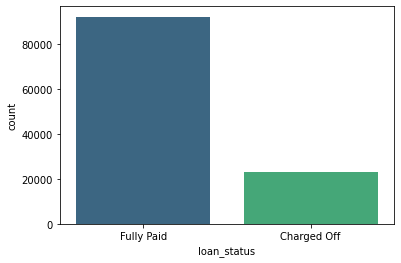

In [10]:
# lets check if loan_status now has only fully paid and charged off
sns.countplot(x=df['loan_status'], data=df, palette='viridis')

It is imbalanced.

# 3. Data Cleaning
<a id="3"></a>

Let's find the % of null values in each column sorted in descending order of missing values.

In [11]:
((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

sec_app_open_act_il       100.0
next_pymnt_d              100.0
member_id                 100.0
revol_bal_joint           100.0
sec_app_fico_range_low    100.0
                          ...  
mo_sin_rcnt_tl              0.0
mort_acc                    0.0
num_accts_ever_120_pd       0.0
revol_bal                   0.0
id                          0.0
Length: 151, dtype: float64

Let's plot the % of missing values.

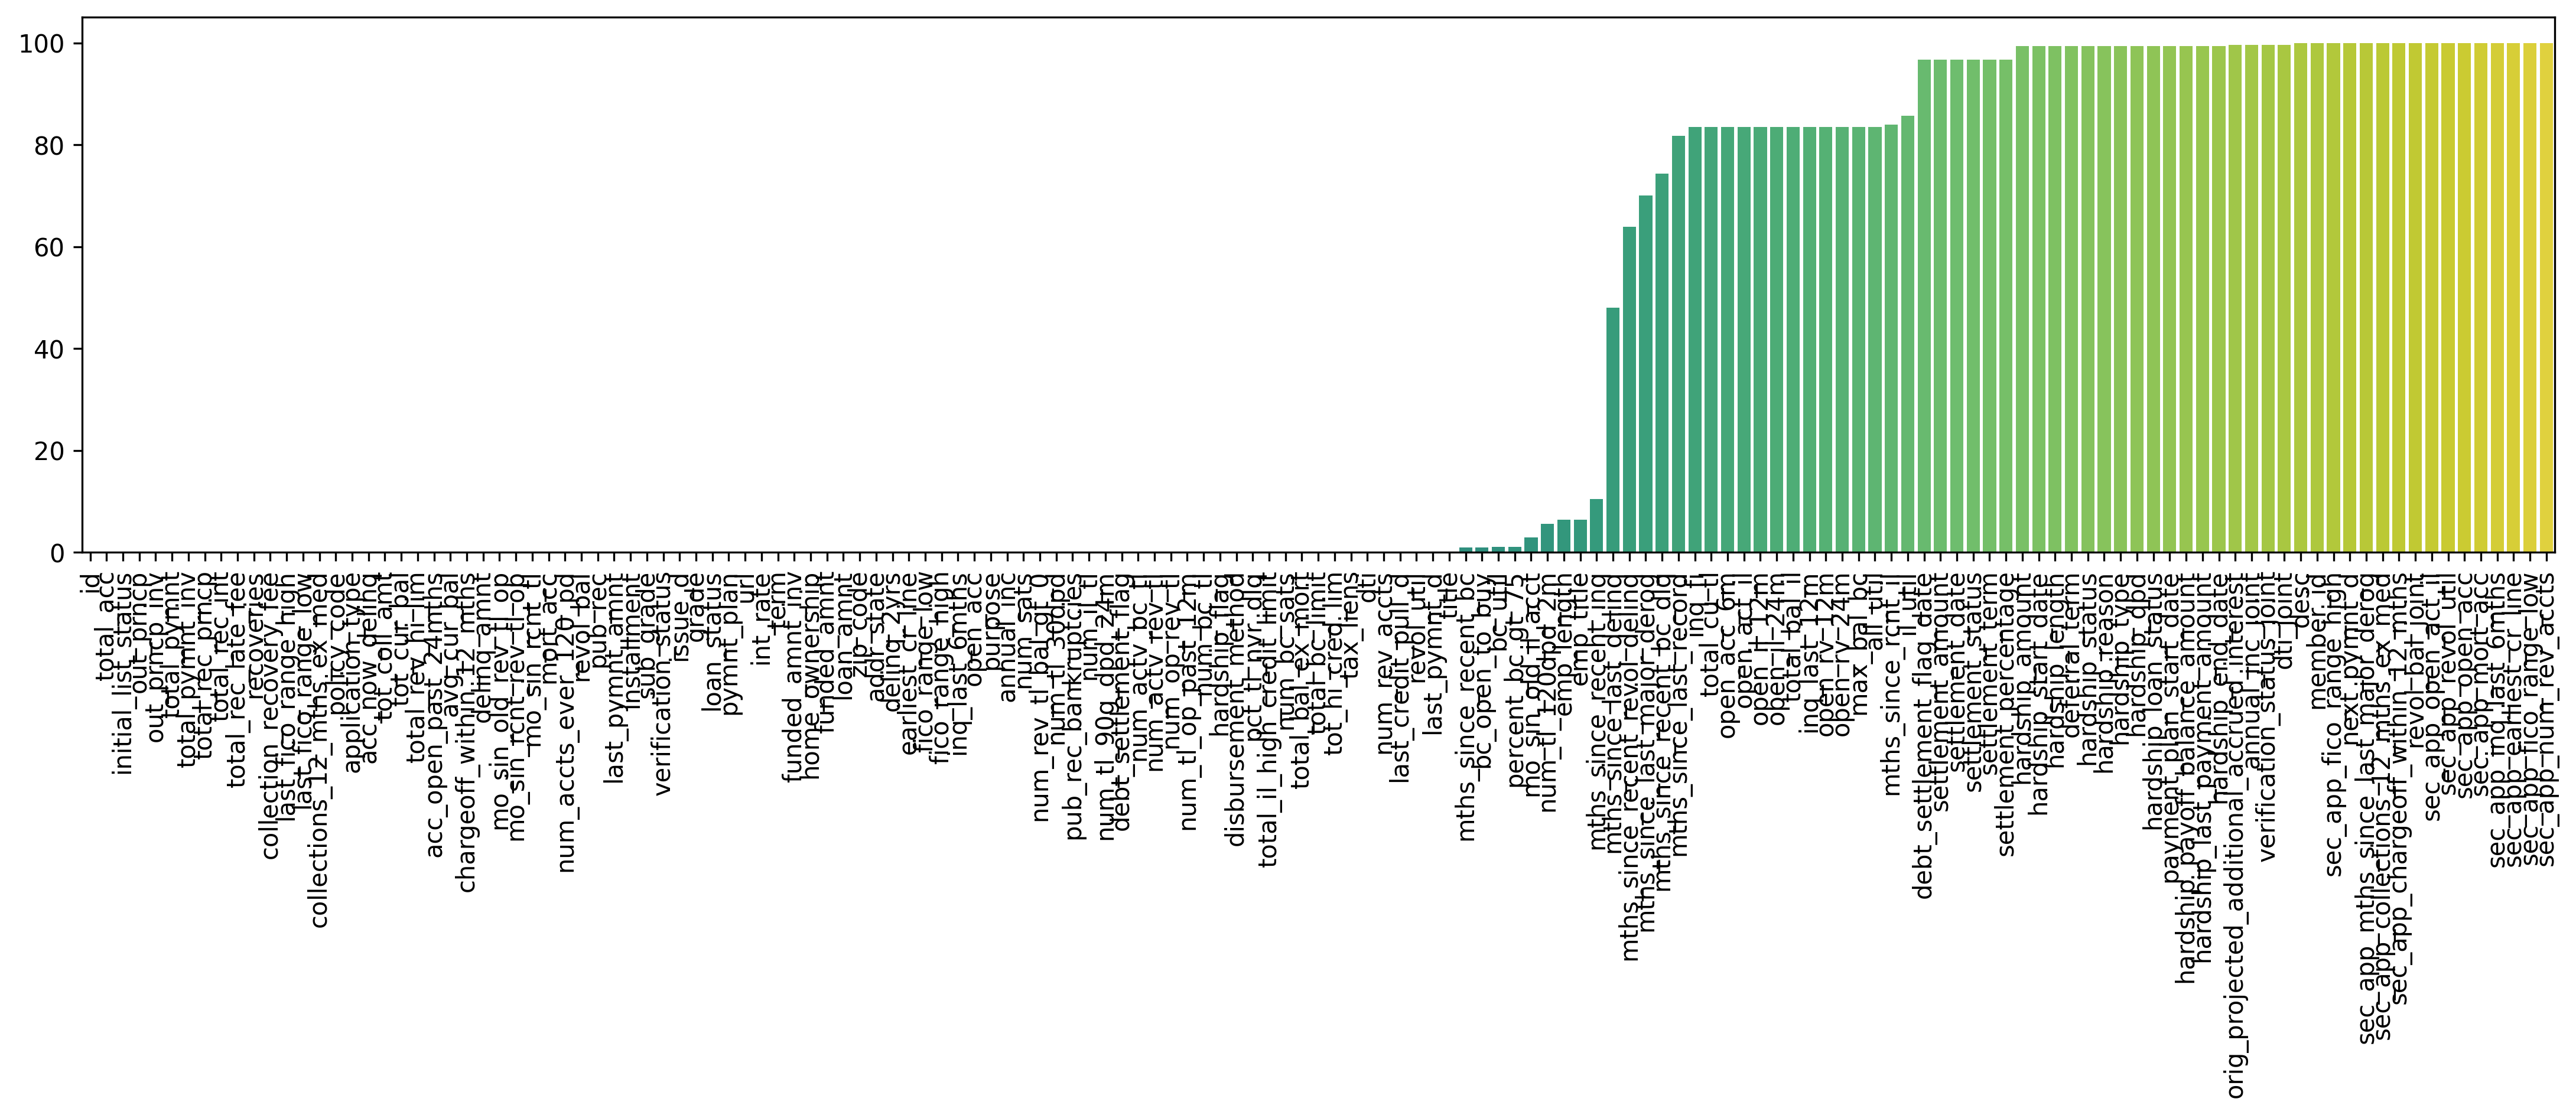

In [12]:
plt.figure(figsize=(18,4),dpi=300) # make image larger and clearer
# y contains the % of missing values od each column and x is the index of the series in above cell
sns.barplot(y=((df.isnull().sum()/len(df))*100).sort_values(), x=((df.isnull().sum()/len(df))*100).sort_values().index, palette='viridis') 
plt.xticks(rotation=90); # to rotate x-axis labels from horizontal to vertical

Lets drop the features with 50% or more missing data since, 1. It is difficult to fill in values for so many missing rows, 2. There are 151 features, we need to reduce them significantly because the size of the data set (1345310 rows) otherwise the hardware would not be able to support the data set.

In [13]:
keep = df.columns[((df.isnull().sum()/len(df))*100 < 50)].to_list()
keep # list of columns to be kept

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_ope

In [14]:
len(keep)

94

In [15]:
df = df[keep] # dropping features with 50% or more missing data

In [16]:
df.shape

(115107, 94)

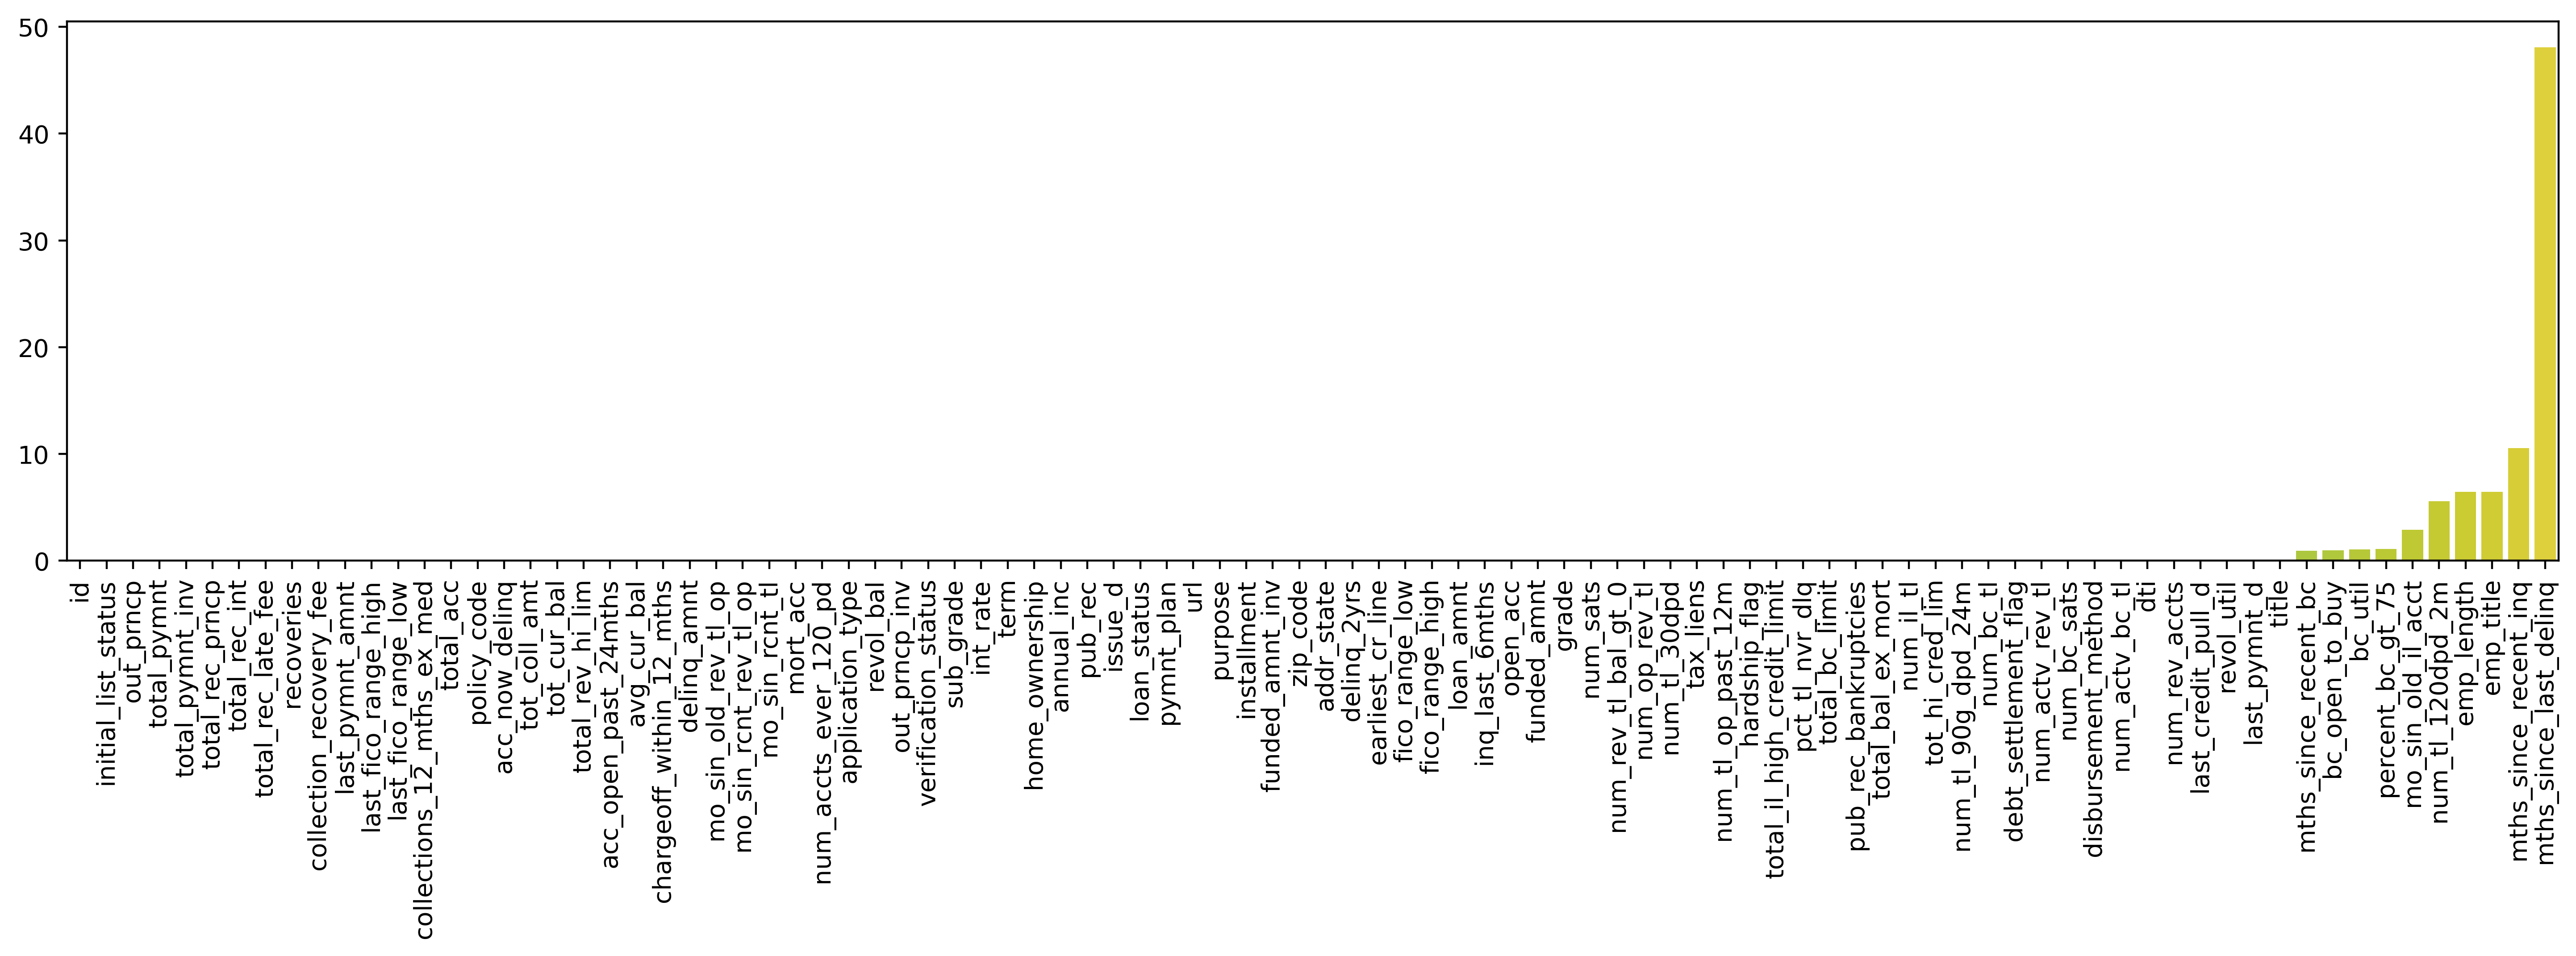

In [17]:
plt.figure(figsize=(18,4),dpi=400)
sns.barplot(y=((df.isnull().sum()/len(df))*100).sort_values(), x=((df.isnull().sum()/len(df))*100).sort_values().index, palette='viridis')
plt.xticks(rotation=90);

Since we don't have a clear understanding for many features, it would be unwise to include them into our analysis without truly understanding a feature. \
Moreover, not all features will be available to us before a person gets loan. \
Some features will only be available after a person gets a loan. We have the following features we will be proceeding with:

In [18]:
final_features = ['addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'application_type',
                    'initial_list_status', 'int_rate', 'loan_amnt', 'num_actv_bc_tl', 'loan_status', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
                    'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status']

In [19]:
df = df[final_features]

In [20]:
df.shape
# We now have 27 features to play with (loan_status is the output)

(115107, 28)

# 4. Preprocessing, Exploratory Analysis and Feature Engineering
<a id="4"></a>

In [21]:
df

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status
0,PA,55000.0,Aug-2003,10+ years,leadman,679.0,675.0,C,MORTGAGE,Individual,...,0.0,0.0,debt_consolidation,2765.0,29.7,C4,36 months,Debt consolidation,13.0,Not Verified
1,SD,65000.0,Dec-1999,10+ years,Engineer,719.0,715.0,C,MORTGAGE,Individual,...,0.0,0.0,small_business,21470.0,19.2,C1,36 months,Business,38.0,Not Verified
2,IL,63000.0,Aug-2000,10+ years,truck driver,699.0,695.0,B,MORTGAGE,Joint App,...,0.0,0.0,home_improvement,7869.0,56.2,B4,60 months,NaN,18.0,Not Verified
4,PA,104433.0,Jun-1998,3 years,Contract Specialist,699.0,695.0,F,MORTGAGE,Individual,...,0.0,0.0,major_purchase,21929.0,64.5,F1,60 months,Major purchase,35.0,Source Verified
5,GA,34000.0,Oct-1987,4 years,Veterinary Tecnician,694.0,690.0,C,RENT,Individual,...,0.0,0.0,debt_consolidation,8822.0,68.4,C3,36 months,Debt consolidation,6.0,Source Verified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130765,CO,74000.0,Jul-2009,7 years,sales support,719.0,715.0,C,MORTGAGE,Individual,...,0.0,0.0,debt_consolidation,6853.0,38.3,C3,60 months,Debt consolidation,24.0,Not Verified
130766,FL,54000.0,Dec-2001,6 years,Loan Servicing,689.0,685.0,A,RENT,Individual,...,0.0,0.0,credit_card,10452.0,83.0,A2,36 months,Credit card refinancing,15.0,Source Verified
130767,TX,40000.0,Oct-2010,< 1 year,Sales Excec,689.0,685.0,C,RENT,Individual,...,0.0,0.0,debt_consolidation,8594.0,54.1,C3,36 months,Debt consolidation,7.0,Source Verified
130768,OH,102000.0,Oct-1996,10+ years,signal foreman,724.0,720.0,B,MORTGAGE,Individual,...,0.0,0.0,debt_consolidation,20982.0,36.6,B1,36 months,Debt consolidation,46.0,Source Verified


In [22]:
df.dtypes.value_counts()

object     14
float64    14
dtype: int64

There are 14 categorical features currently.

In [23]:
df['loan_status'] # The feature we need to predict

0          Fully Paid
1          Fully Paid
2          Fully Paid
4          Fully Paid
5          Fully Paid
             ...     
130765     Fully Paid
130766     Fully Paid
130767    Charged Off
130768     Fully Paid
130769     Fully Paid
Name: loan_status, Length: 115107, dtype: object

Create dummies for loan_status so that correlation can be calculated wrt to loan_status for other continuous features.

In [24]:
df_temp = df.copy() # copy so that it does not affect the original data frame
df_temp['loan_status'] = pd.get_dummies(df_temp['loan_status'], drop_first=True)

If you are unsure what drop_first=True does, check this out: https://stackoverflow.com/questions/63661560/drop-first-true-during-dummy-variable-creation-in-pandas.

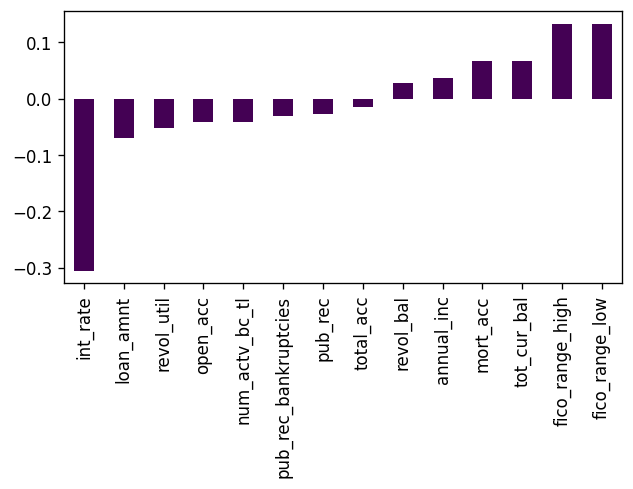

In [25]:
plt.figure(figsize=(6,3),dpi=120)
df_temp.corr()['loan_status'].sort_values().drop('loan_status').plot(kind='bar', cmap='viridis') # correlation with loan_status for continuous features with loan_status feature dropped
plt.xticks(rotation=90); 

int_rate, fico_range_high and fico_range_low are highly correlated with loan_status compared to other features.

Lets calculate features with missing values. 

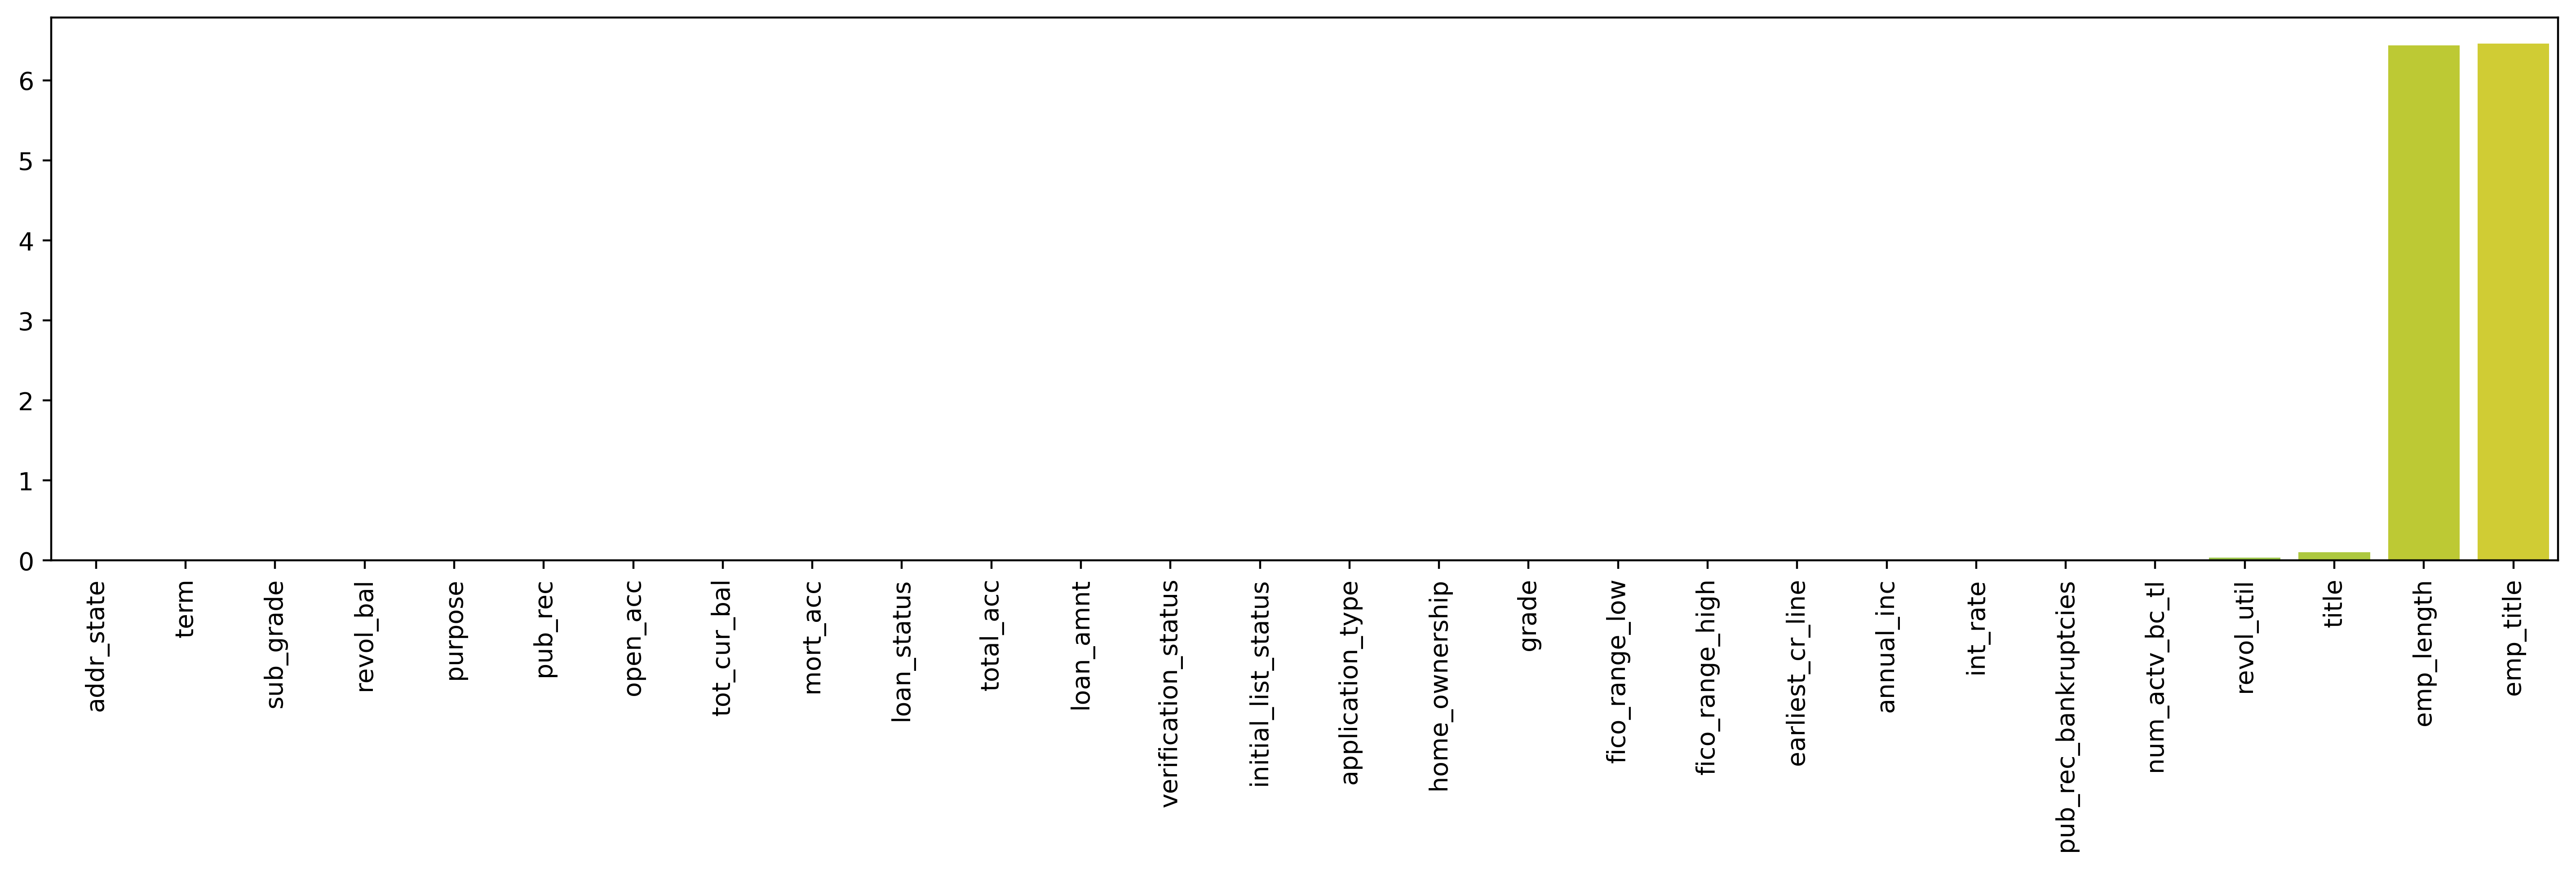

In [26]:
plt.figure(figsize=(18,4),dpi=400)
sns.barplot(y=((df.isnull().sum()/len(df))*100).sort_values(), x=((df.isnull().sum()/len(df))*100).sort_values().index, palette='viridis')
plt.xticks(rotation=90);

Columns with missing values and % of missing values.

In [27]:
df_missing = ((df.isnull().sum()/len(df))*100)[((df.isnull().sum()/len(df))*100) > 0]
df_missing

emp_length              6.437489
emp_title               6.460076
num_actv_bc_tl          0.000869
pub_rec_bankruptcies    0.000869
revol_util              0.036488
title                   0.102513
dtype: float64

Create a function to check % of missing data for a particular column.

In [28]:
def if_null_values(feat_name):
    if feat_name in df_missing:
        return(f"% of missing values = {df_missing[feat_name].round(2)}")
    else:
        return("No missing values")

Let us examine each feature, drop those which seem unimportant and create dummies for the ones which are categorical.

## 4.1 addr_state
<a id="4.1"></a>

The state provided by the borrower in the loan application.

In [29]:
if_null_values('addr_state')

'No missing values'

In [30]:
df['addr_state'].unique() # unique values in this feature

array(['PA', 'SD', 'IL', 'GA', 'MN', 'SC', 'RI', 'NC', 'CA', 'VA', 'AZ',
       'IN', 'MD', 'NY', 'TX', 'KS', 'NM', 'AL', 'WA', 'OH', 'LA', 'FL',
       'CO', 'MI', 'MO', 'DC', 'MA', 'WI', 'HI', 'VT', 'NJ', 'DE', 'TN',
       'NH', 'NE', 'OR', 'CT', 'AR', 'NV', 'WV', 'MT', 'WY', 'OK', 'KY',
       'MS', 'UT', 'ND', 'ME', 'AK'], dtype=object)

In [31]:
len(df['addr_state'].unique())

49

For some reason number of states is 51, rather than 50. I don't have the required info about which extra 'state' is present here. We'll proceed with 51 states.

In [32]:
df['addr_state'].value_counts()

CA    15959
TX     9696
NY     9449
FL     8187
IL     4568
NJ     4071
PA     3948
GA     3835
OH     3796
VA     3241
NC     3164
MI     3157
AZ     2799
MD     2716
MA     2516
CO     2435
WA     2310
MN     2078
TN     1952
IN     1925
MO     1873
CT     1654
NV     1607
WI     1532
AL     1459
SC     1341
LA     1274
OR     1271
KY     1110
OK     1049
KS      981
AR      905
UT      794
MS      726
NM      645
NE      565
HI      553
NH      549
RI      453
ME      409
WV      387
ND      359
MT      324
DE      318
DC      284
SD      227
AK      227
VT      215
WY      214
Name: addr_state, dtype: int64

This is a categorical feature which needs to be converted into dummies.

In [33]:
add_state_dummies = pd.get_dummies(df['addr_state'], drop_first=True) # drop_first will drop the first dummy column 
add_state_dummies

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130765,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130766,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
130767,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
130768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Drop 'addr_state' feature and concat 'add_state_dummies' to df.

In [34]:
df = pd.concat([df.drop('addr_state', axis=1), add_state_dummies], axis=1)

## 4.2 annual_inc
<a id="4.2"></a>

The self-reported annual income provided by the borrower during registration.

In [35]:
if_null_values('annual_inc')

'No missing values'

In [36]:
df['annual_inc'].describe()

count    1.151070e+05
mean     7.787250e+04
std      8.915764e+04
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.270000e+04
max      9.000000e+06
Name: annual_inc, dtype: float64

Plot the distribution of annual incomes

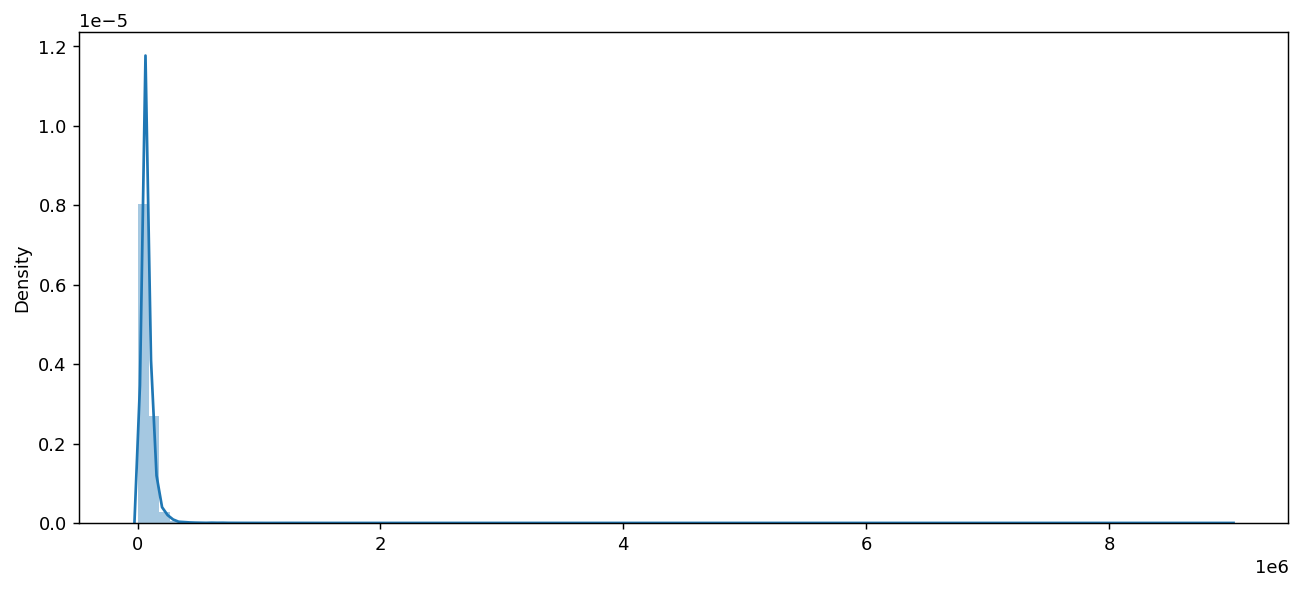

In [37]:
plt.figure(figsize=(12,5), dpi=130)
sns.distplot(x=df['annual_inc'], bins=100)

The salary distribution is highly skewed towards right.<br>
Let's find how many customers have annual_inc > $250000.

In [38]:
len(df[df['annual_inc'] > 250000])

1280

% of rows with annual income > $250000.

In [39]:
percent_of_rows_of_customers_with_annual_inc_more_than_250000 = 13447*100/len(df) 

In [40]:
percent_of_rows_of_customers_with_annual_inc_more_than_250000

11.682173977255944

There are 13447 rows of customers with annual_inc > 250000, i.e., 1%. Since these are outliers, let's drop these rows.

Lets remove the rows with annual_inc > $250000

In [41]:
df = df[df['annual_inc'] <= 250000]

In [42]:
len(df)

113827

We have removed those 1749 rows. We had 1345310 rows initially and after droping 13447 rows we have 1331863 rows.

Let's check the distribution now.

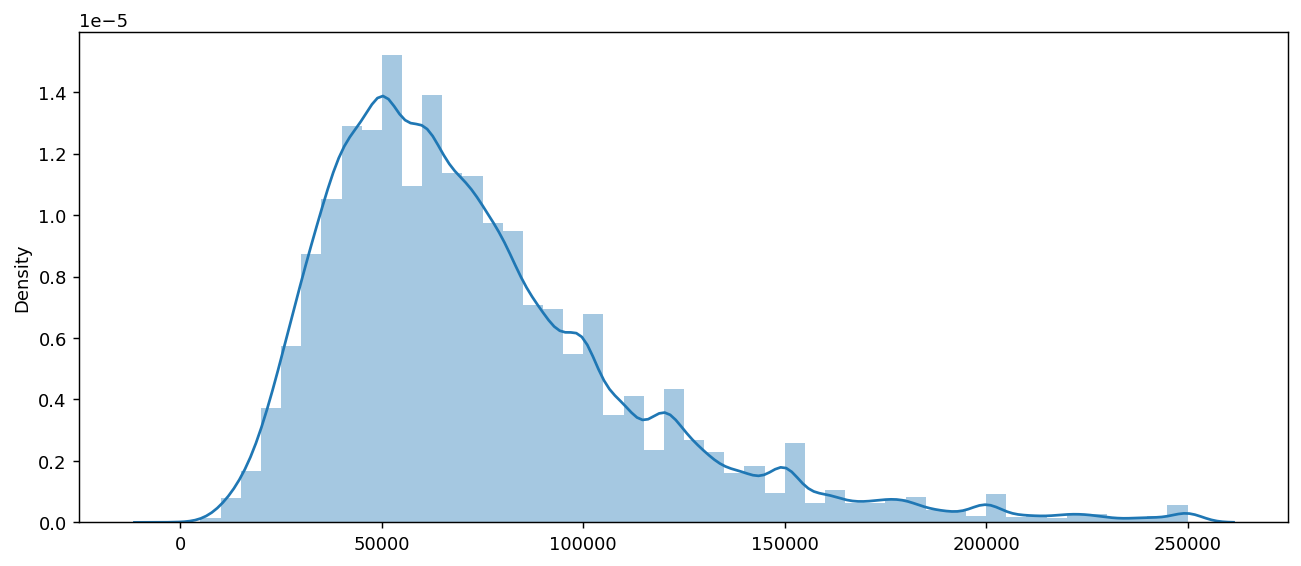

In [43]:
plt.figure(figsize=(12,5), dpi=130)
sns.distplot(x=df['annual_inc']);

It is still a bit skewed but exceedingly better than before.

Lets check the distributions of annual income of customers who fully paid the loan whose loan was charged off.

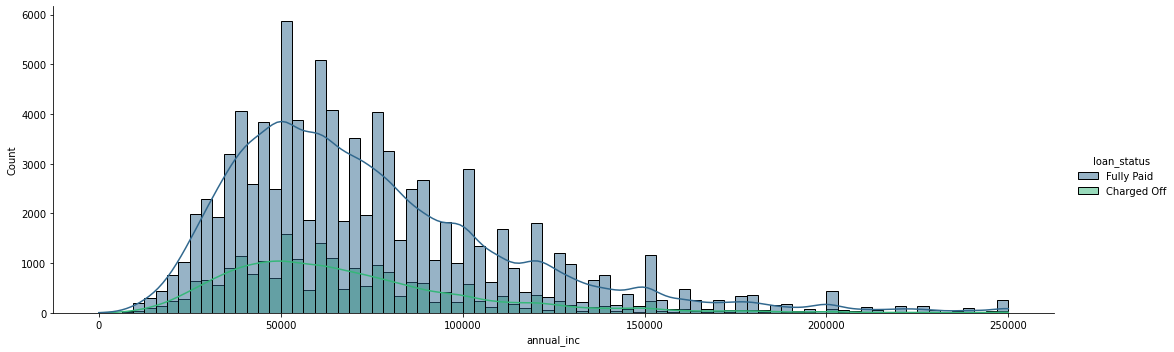

In [44]:
sns.displot(data=df, x='annual_inc', hue='loan_status', bins=80, height=5, aspect=3, kde=True, palette='viridis');

In [45]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22746.0,68832.710085,35892.669211,0.0,44500.0,60000.0,85000.0,250000.0
Fully Paid,91081.0,74756.510754,39601.108460,0.0,47000.0,65000.0,93715.0,250000.0


The mean annual_inc for customers who fully paid the loan and who did not differs by around $5000.

## 4.3 earliest_cr_line
<a id="4.3"></a>

The month the borrower's earliest reported credit line was opened.

In [46]:
if_null_values('earliest_cr_line')

'No missing values'

In [47]:
df['earliest_cr_line'].head()

0    Aug-2003
1    Dec-1999
2    Aug-2000
4    Jun-1998
5    Oct-1987
Name: earliest_cr_line, dtype: object

Lets remove the month and just keep the year as integer.

In [48]:
df["earliest_cr_line"]

0         Aug-2003
1         Dec-1999
2         Aug-2000
4         Jun-1998
5         Oct-1987
            ...   
130765    Jul-2009
130766    Dec-2001
130767    Oct-2010
130768    Oct-1996
130769    May-1997
Name: earliest_cr_line, Length: 113827, dtype: object

In [49]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))

Lets check if that worked.

In [50]:
df['earliest_cr_line'].head()

0    2003
1    1999
2    2000
4    1998
5    1987
Name: earliest_cr_line, dtype: int64

Check distribution of earliest_cr_line of customers who Fully Paid the loan and customers who did not.

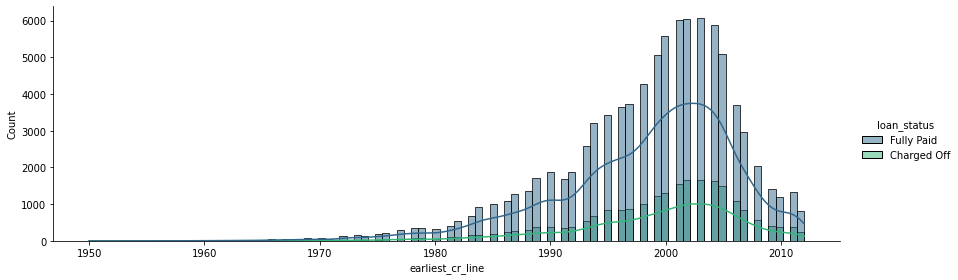

In [51]:
sns.displot(data=df, x='earliest_cr_line', hue='loan_status', bins=100, height=4, aspect=3, kde=True, palette='viridis');

In [52]:
df.groupby('loan_status')['earliest_cr_line'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22746.0,1999.240394,7.560724,1955.0,1996.0,2001.0,2004.0,2012.0
Fully Paid,91081.0,1998.474446,7.664735,1950.0,1994.0,2000.0,2004.0,2012.0


Mean earliest_cr_line for customers who fully paid the loan was approx. 1 year before the customers who did not pay the loan.

## 4.4 emp_length
<a id="4.4"></a>

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [53]:
if_null_values('emp_length')

'% of missing values = 6.44'

In [54]:
df['emp_length'].head()

0    10+ years
1    10+ years
2    10+ years
4      3 years
5      4 years
Name: emp_length, dtype: object

Create an ascending order list 

In [55]:
emp_length_order = [ '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

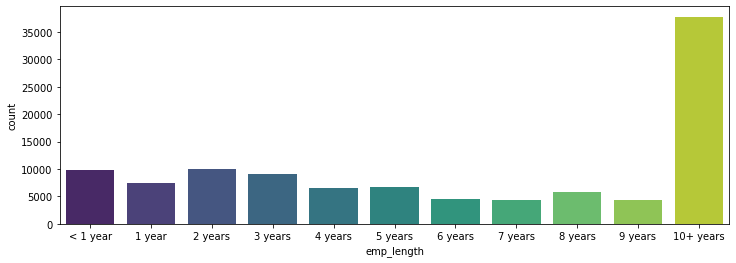

In [56]:
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df,order=emp_length_order, palette='viridis')

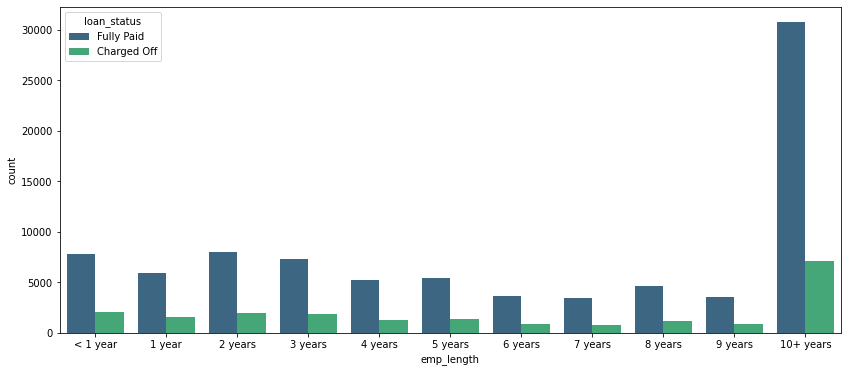

In [57]:
plt.figure(figsize=(14,6))
sns.countplot(x='emp_length',data=df,order=emp_length_order,hue='loan_status', palette='viridis')

This is still not indicating if there's any relationship between emp_length and being charged off. Let us find % of charged off customers per year.

In [58]:
emp_charged_off = df[df['loan_status']=="Charged Off"].groupby("emp_length").count()['loan_status']
emp_fully_paid = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']
percentage_charged_off = (emp_charged_off * 100)/(emp_charged_off + emp_fully_paid)
percentage_charged_off

emp_length
1 year       20.847867
10+ years    18.699876
2 years      19.861013
3 years      20.454297
4 years      19.917203
5 years      20.254853
6 years      19.509476
7 years      18.713450
8 years      19.731174
9 years      20.831451
< 1 year     20.611230
Name: loan_status, dtype: float64

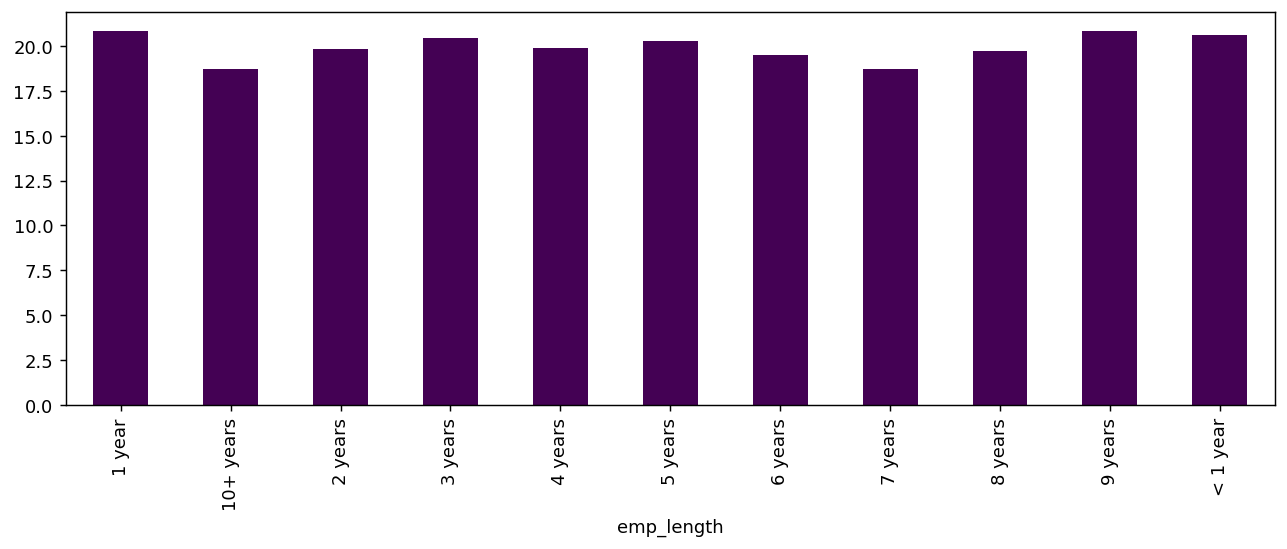

In [59]:
plt.figure(figsize=(12,4), dpi=130)
percentage_charged_off.plot(kind='bar', cmap='viridis')

There is not much differnce. This feature won't make much differnece in our training and predictions. Hence, its better to drop this feature.

In [60]:
df = df.drop('emp_length', axis=1)

In [61]:
df.columns

Index(['annual_inc', 'earliest_cr_line', 'emp_title', 'fico_range_high',
       'fico_range_low', 'grade', 'home_ownership', 'application_type',
       'initial_list_status', 'int_rate', 'loan_amnt', 'num_actv_bc_tl',
       'loan_status', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'AL',
       'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IL', 'IN',
       'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [62]:
df.shape

(113827, 74)

## 4.5 emp_title
<a id="4.5"></a>

The job title supplied by the Borrower when applying for the loan.

In [63]:
if_null_values('emp_title')

'% of missing values = 6.46'

In [64]:
df['emp_title'].describe()

count      106405
unique      41623
top       Teacher
freq         2157
Name: emp_title, dtype: object

There are 378007 unique values, way too many to create dummies. Hence, it is wise to drop this feature.

In [65]:
df = df.drop('emp_title', axis=1)

## 4.6 fico_range_high and fico_range_low
<a id="4.6"></a>

In [66]:
df['fico_range_high'].describe()

count    113827.000000
mean        698.299103
std          30.967893
min         664.000000
25%         674.000000
50%         689.000000
75%         714.000000
max         850.000000
Name: fico_range_high, dtype: float64

In [67]:
df['fico_range_low'].describe()

count    113827.000000
mean        694.298980
std          30.967293
min         660.000000
25%         670.000000
50%         685.000000
75%         710.000000
max         845.000000
Name: fico_range_low, dtype: float64

Both fico_range_high and fico_range_low have similar mean and standard deviation. So, we will use mean of both scores.

In [68]:
df['fico'] = (df['fico_range_high'] + df['fico_range_low']) / 2
df['fico']

0         677.0
1         717.0
2         697.0
4         697.0
5         692.0
          ...  
130765    717.0
130766    687.0
130767    687.0
130768    722.0
130769    712.0
Name: fico, Length: 113827, dtype: float64

Lets drop the original columns.

In [69]:
df = df.drop(['fico_range_high', 'fico_range_low'], axis=1)

In [70]:
df.shape

(113827, 72)

Let's check the distribution now.

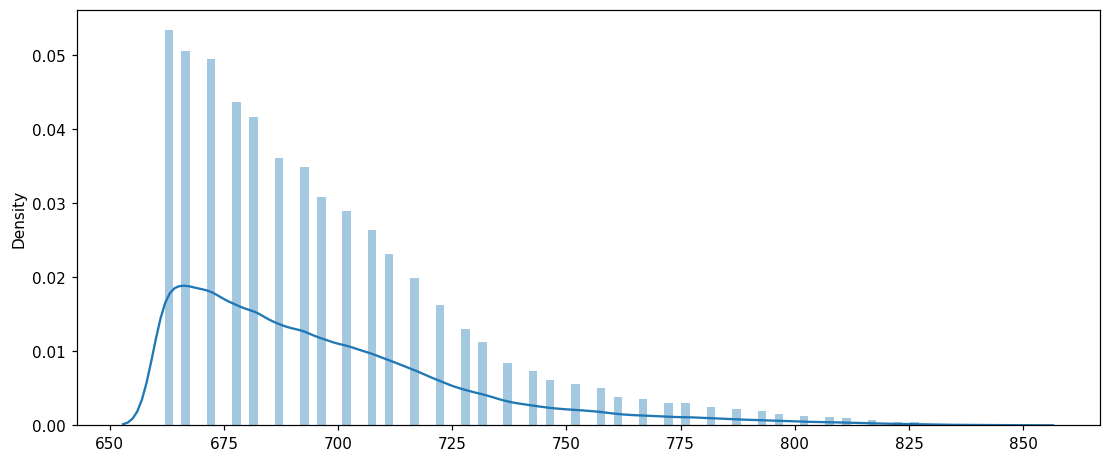

In [71]:
plt.figure(figsize=(12,5), dpi=110)
sns.distplot(x=df['fico'], bins=100)

Check distribution of fico score of customers who Fully Paid the loan and customers who did not.

<Figure size 6000x2100 with 0 Axes>

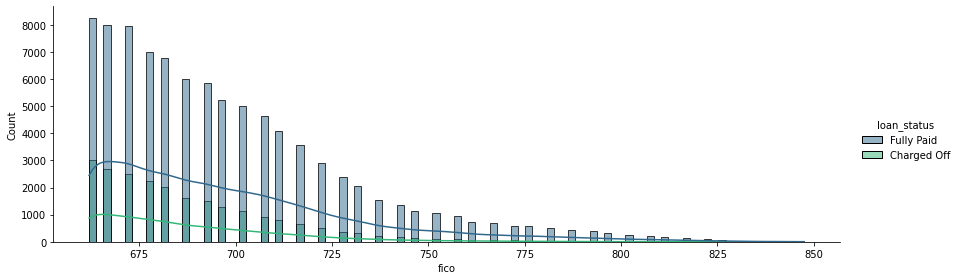

In [72]:
plt.figure(figsize=(20,7), dpi=300)
sns.displot(data=df, x='fico', hue='loan_status', bins=100, height=4, aspect=3, kde=True, palette='viridis')

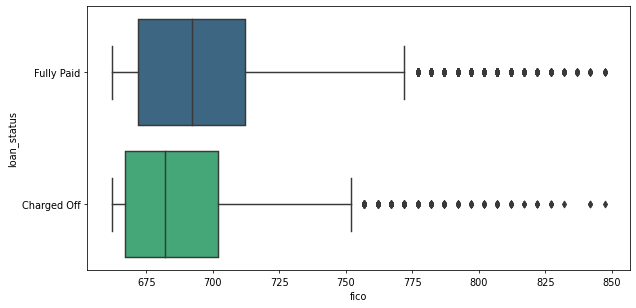

In [73]:
plt.figure(figsize=(10,5), dpi=70)
sns.boxplot(data=df, y='loan_status', x='fico', palette='viridis')

In [74]:
df.groupby('loan_status')['fico'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22746.0,688.135826,24.615344,662.0,667.0,682.0,702.0,847.5
Fully Paid,91081.0,698.337672,32.037112,662.0,672.0,692.0,712.0,847.5


There is a differnce between fico scores of customers who Fully paid loan and wh did not.

## 4.7 grade and sub_grade
<a id="4.7"></a>

LC assigned loan grade and sub grade.

Let's check unique grade and sub_grade categories.

In [75]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [76]:
sorted(df['sub_grade'].unique())

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5']

Check number of cutomers separated by grade and based on their loan_status.

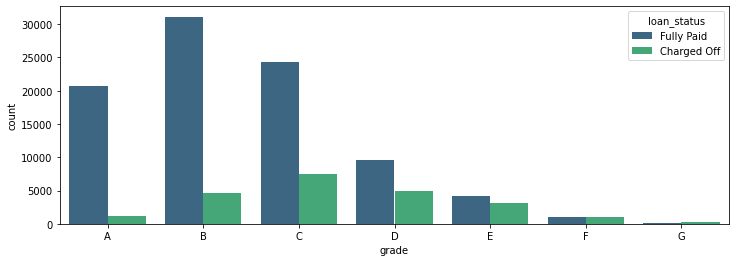

In [77]:
plt.figure(figsize=(12,4))
sns.countplot(x='grade',data=df,hue='loan_status', order=sorted(df['grade'].unique()), palette='viridis');

Check number of customers in each sub_grade.

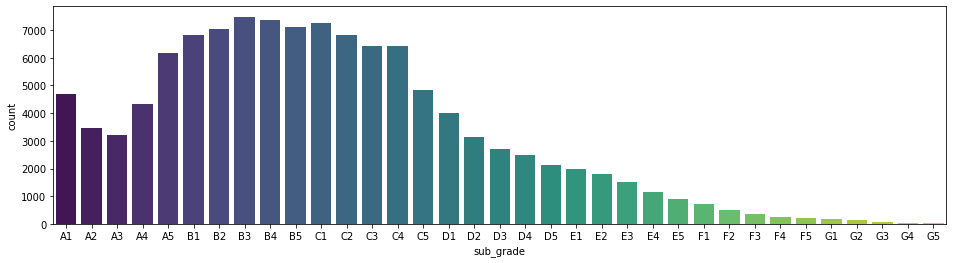

In [78]:
plt.figure(figsize=(16,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='viridis')

Check number of customers in each sub_grade separated by loan_status

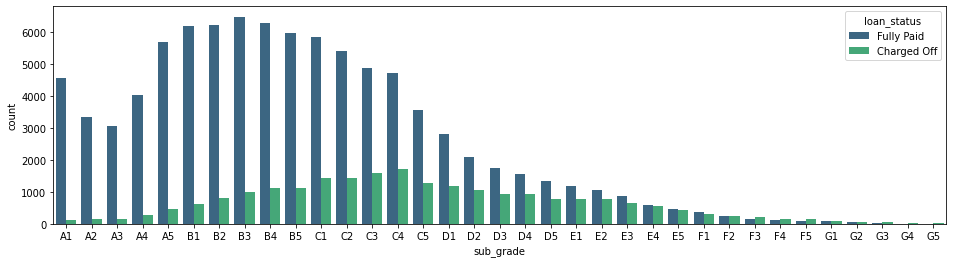

In [79]:
plt.figure(figsize=(16,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='viridis' ,hue='loan_status')

Customers who don't pay back loan have higher grade.<br>
Information of 'grade' is already embedded in 'sub_grade'.<br>
Let's drop 'grade' feature.

In [80]:
df = df.drop('grade', axis=1)

As sub_grade is categorical, lets create dummies for the same.

In [81]:
dummies_sub_grade = pd.get_dummies(df['sub_grade'], drop_first=True)

Concat the 'dummies_sub_grade' after dropping the original feature 'sub_grade'.

In [82]:
df = pd.concat([df.drop('sub_grade', axis=1), dummies_sub_grade], axis=1)

In [83]:
df.shape

(113827, 104)

## 4.8 home_ownership
<a id="4.8"></a>

The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [84]:
if_null_values('home_ownership')

'No missing values'

In [85]:
df['home_ownership'].value_counts()

MORTGAGE    55450
RENT        45490
OWN         12886
ANY             1
Name: home_ownership, dtype: int64

Let's merge 'ANY' and 'NONE' into 'OTHER'.

In [86]:
df['home_ownership'] = df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

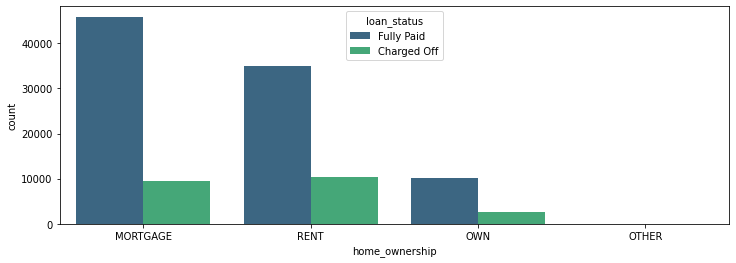

In [87]:
plt.figure(figsize=(12,4))
sns.countplot(x='home_ownership',data=df,hue='loan_status', palette='viridis')

In [88]:
df['home_ownership'].value_counts()

MORTGAGE    55450
RENT        45490
OWN         12886
OTHER           1
Name: home_ownership, dtype: int64

Percentage charged off per home_ownership category.

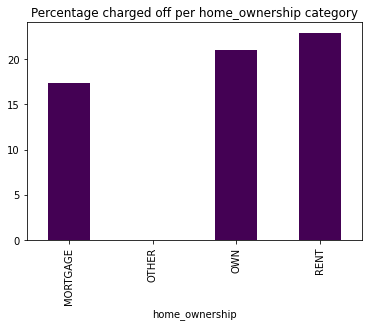

In [89]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("home_ownership").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("home_ownership").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per home_ownership category");

Visible differences between different categories of home_ownership.

Since there are only 4 categories in home_ownership column, we will convert it into dummies.

In [90]:
dummies_home_ownership = pd.get_dummies(df['home_ownership'], drop_first=True)

Concat the 'dummies_home_ownership' after dropping the original feature 'home_ownership'

In [91]:
df = pd.concat([df.drop('home_ownership', axis=1), dummies_home_ownership], axis=1)

In [92]:
df.shape

(113827, 106)

## 4.9 application_type
<a id="4.9"></a>

Indicates whether the loan is an individual application or a joint application with two co-borrowers.

In [93]:
if_null_values('application_type')

'No missing values'

In [94]:
df['application_type'].value_counts()

Individual    113426
Joint App        401
Name: application_type, dtype: int64

Let's plot a countplot for different categories for application types, separated by loan_status.

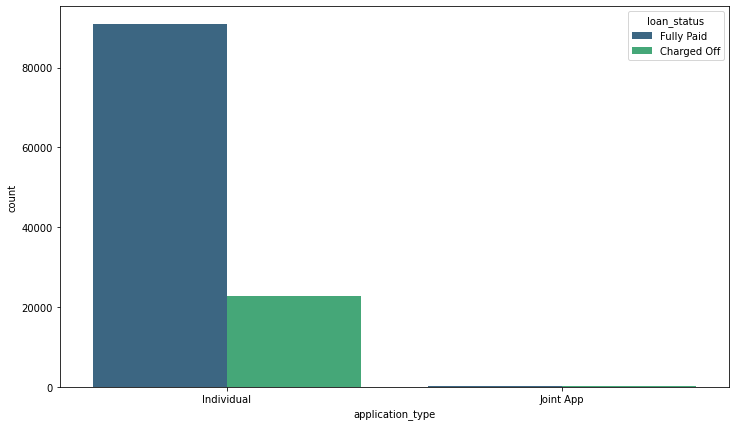

In [95]:
plt.figure(figsize=(12,7))
sns.countplot(x='application_type',data=df,hue='loan_status', palette='viridis');

Percentage charged off per application_type category.

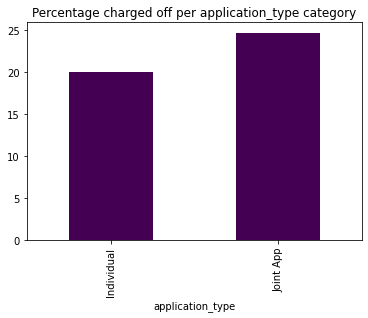

In [96]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("application_type").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("application_type").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per application_type category");

Visible differences between different categories of home_ownership.

Since, this feature is categorical, let's create dummy variables. We will also drop the original feature (application_type) and concat the newly created dummy features.

In [97]:
dummies_application_type = pd.get_dummies(df['application_type'], drop_first=True)
df = pd.concat([df.drop('application_type', axis=1), dummies_application_type], axis=1)

## 4.10 initial_list_status
<a id="4.10"></a>

The initial listing status of the loan. Possible values are – W, F.

In [98]:
if_null_values('initial_list_status')

'No missing values'

In [99]:
df['initial_list_status'].value_counts()

w    84324
f    29503
Name: initial_list_status, dtype: int64

Let's plot 'initial_list_status' for the two 'loan_status'.

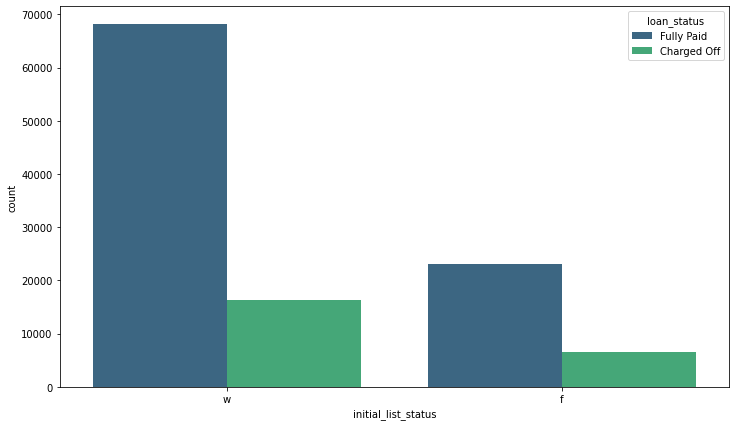

In [100]:
plt.figure(figsize=(12,7))
sns.countplot(x='initial_list_status',data=df,hue='loan_status', palette='viridis');

Percentage charged off per initial_list_status category.

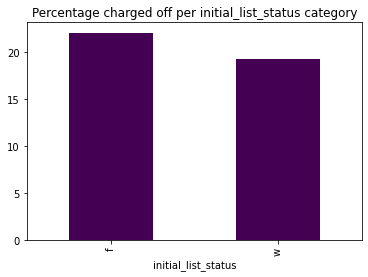

In [101]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("initial_list_status").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("initial_list_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per initial_list_status category");

Percentage charged off is almost same. Let's drop this feature.

In [102]:
df = df.drop('initial_list_status', axis=1)

## 4.11 int_rate
<a id="4.11"></a>

Interest Rate on the loan.

In [103]:
if_null_values('int_rate')

'No missing values'

In [104]:
df['int_rate'].describe()

count    113827.000000
mean         12.013085
std           4.159959
min           5.320000
25%           8.490000
50%          11.530000
75%          14.330000
max          28.990000
Name: int_rate, dtype: float64

In [105]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22746.0,14.551155,4.271478,5.32,11.53,13.99,17.57,28.99
Fully Paid,91081.0,11.379244,3.880738,5.32,8.18,10.99,13.67,28.99


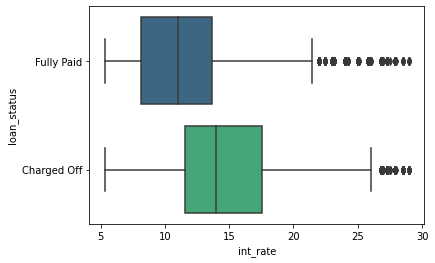

In [106]:
sns.boxplot(data=df, y='loan_status', x='int_rate', palette='viridis');

Clear difference can be seen in the mean 'int_rate' between the two 'loan_status' categories.

## 4.12 loan_amnt
<a id="4.12"></a>

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [107]:
if_null_values('loan_amnt')

'No missing values'

In [108]:
df['loan_amnt'].describe()

count    113827.000000
mean      14318.075457
std        8510.975111
min        1000.000000
25%        7975.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

In [109]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22746.0,15579.526071,8560.258406,1000.0,9150.0,14600.0,20575.0,35000.0
Fully Paid,91081.0,14003.048660,8469.401032,1000.0,7300.0,12000.0,20000.0,35000.0


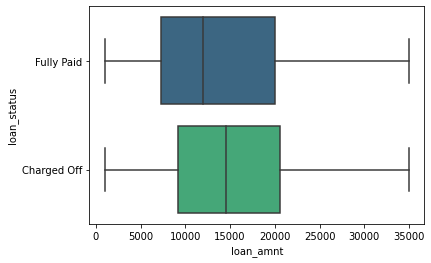

In [110]:
sns.boxplot(data=df, y='loan_status', x='loan_amnt', palette='viridis');

Clear difference can be seen in the mean 'loan_amnt' between the two 'loan_status' categories.

## 4.13 num_actv_bc_tl
<a id="4.13"></a>

Number of currently active bankcard accounts.

In [111]:
if_null_values('num_actv_bc_tl')

'% of missing values = 0.0'

In [112]:
df['num_actv_bc_tl'].describe()

count    113826.000000
mean          3.666781
std           2.299893
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          26.000000
Name: num_actv_bc_tl, dtype: float64

Range of num_actv_bc_tl is from 0 to 35 with mean at 3.64 and mojority of values between 2 to 5. Lets fill the missing values with the integer value closest to mean, i.e., 4.

In [113]:
df['num_actv_bc_tl'] = df['num_actv_bc_tl'].fillna(4)

In [114]:
df['num_actv_bc_tl'].isnull().sum()

0

In [115]:
df.groupby('loan_status')['num_actv_bc_tl'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22746.0,3.862701,2.422074,0.0,2.0,3.0,5.0,26.0
Fully Paid,91081.0,3.617857,2.265713,0.0,2.0,3.0,5.0,26.0


Since there are some outliers, we will drop rows with customers with 'num_actv_bc_tl' > 9.

In [116]:
df = df[df['num_actv_bc_tl'] < 10]

In [117]:
df.groupby('loan_status')['num_actv_bc_tl'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22089.0,3.628231,1.997973,0.0,2.0,3.0,5.0,9.0
Fully Paid,89115.0,3.440027,1.916222,0.0,2.0,3.0,5.0,9.0


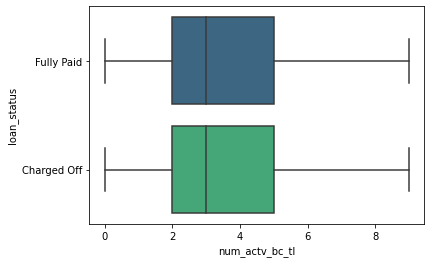

In [118]:
sns.boxplot(data=df, y='loan_status', x='num_actv_bc_tl', palette='viridis')

Minute difference can be seen in the mean 'num_actv_bc_tl' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.14 mort_acc
<a id="4.14"></a>

Number of mortgage accounts.

In [119]:
if_null_values('mort_acc')

'No missing values'

In [120]:
df['mort_acc'].describe()

count    111204.00000
mean          1.62085
std           1.92344
min           0.00000
25%           0.00000
50%           1.00000
75%           3.00000
max          35.00000
Name: mort_acc, dtype: float64

Range of mort_acc is from 0 to 51 with mean at 1.66

In [121]:
df.corr()['num_actv_bc_tl'].sort_values()[:-1]

earliest_cr_line       -0.103348
fico                   -0.069660
pub_rec_bankruptcies   -0.066493
RENT                   -0.044238
pub_rec                -0.035284
                          ...   
annual_inc              0.168840
loan_amnt               0.207889
total_acc               0.246841
revol_bal               0.314377
open_acc                0.478526
Name: num_actv_bc_tl, Length: 99, dtype: float64

'num_actv_bc_tl' and 'open_acc' are closely related. Let's fill missing 'mort_acc' by the mode of corresponding value in 'num_actv_bc_tl'.

In [122]:
df['mort_acc'] = df['mort_acc'].fillna(df.groupby('open_acc')['mort_acc'].transform(lambda x:x.value_counts().index[0]))

In [123]:
df['mort_acc'].isnull().sum()

0

In [124]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22089.0,1.371044,1.768073,0.0,0.0,1.0,2.0,16.0
Fully Paid,89115.0,1.682769,1.955126,0.0,0.0,1.0,3.0,35.0


Since there are some outliers, we will drop rows with customers with mort_acc > 8.

In [125]:
df = df[df['mort_acc'] < 9]

In [126]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22024.0,1.345124,1.702552,0.0,0.0,1.0,2.0,8.0
Fully Paid,88591.0,1.630425,1.825923,0.0,0.0,1.0,3.0,8.0


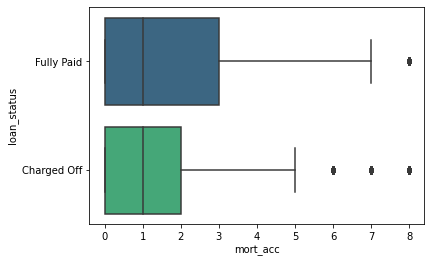

In [127]:
sns.boxplot(data=df, y='loan_status', x='mort_acc', palette='viridis')

Minute difference can be seen in the mean 'mort_acc' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.15 total_acc
<a id="4.15"></a>

The total number of credit lines currently in the borrower's credit file.

In [128]:
if_null_values('total_acc')

'No missing values'

In [129]:
df['total_acc'].describe()

count    110615.000000
mean         24.740180
std          11.812308
min           4.000000
25%          16.000000
50%          23.000000
75%          31.000000
max         135.000000
Name: total_acc, dtype: float64

Let's make a countplot of number of customers with different 'total_acc'.

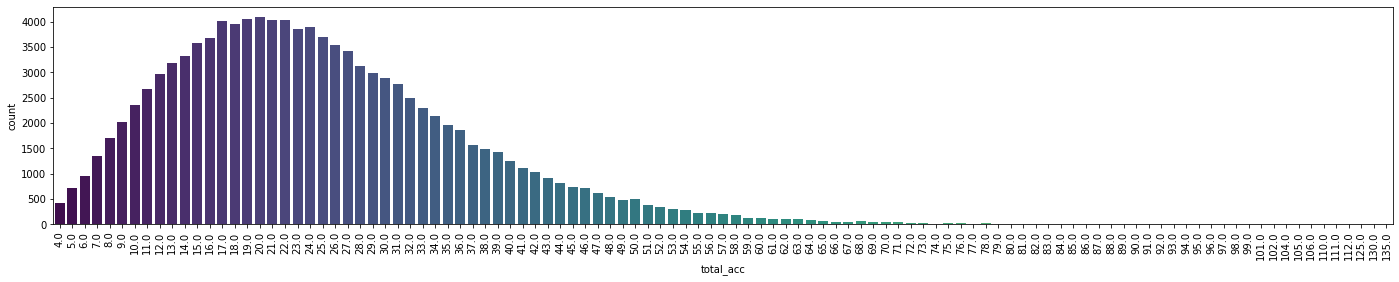

In [130]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='total_acc', palette='viridis');

Since there are some outliers, we will drop rows with customers with 'total_acc' > 63.

In [131]:
df = df[df['total_acc'] < 64]

In [132]:
df.shape

(109911, 105)

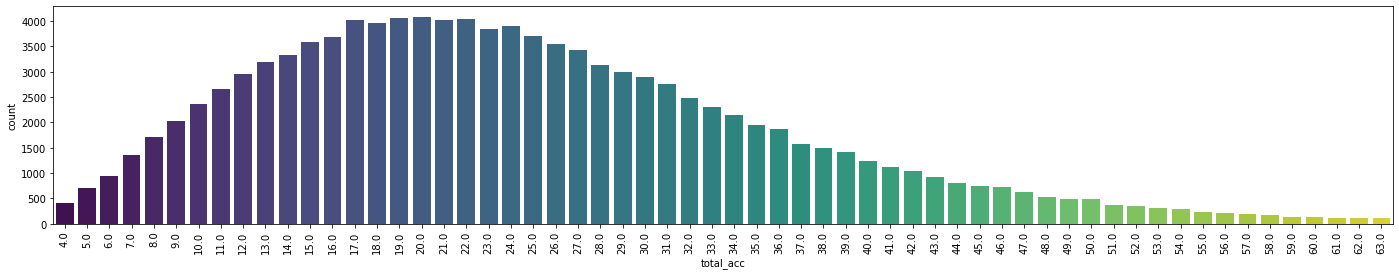

In [133]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='total_acc', palette='viridis');

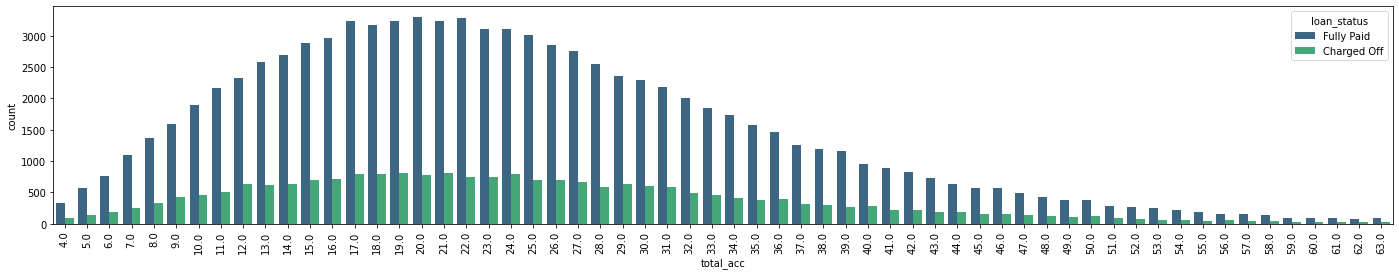

In [134]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='total_acc', hue='loan_status', palette='viridis');

In [135]:
df.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21864.0,24.727269,11.461053,4.0,16.0,23.0,32.0,63.0
Fully Paid,88047.0,24.362943,11.122747,4.0,16.0,23.0,31.0,63.0


Difference can be seen in the mean 'total_acc' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.16 tot_cur_bal
<a id="4.16"></a>

Total current balance of all accounts.

In [136]:
if_null_values('tot_cur_bal')

'No missing values'

In [137]:
df['tot_cur_bal'].describe()

count    1.099110e+05
mean     1.319889e+05
std      1.410245e+05
min      0.000000e+00
25%      2.919750e+04
50%      7.372300e+04
75%      1.987990e+05
max      2.276535e+06
Name: tot_cur_bal, dtype: float64

Let's fill null values with mean.

In [138]:
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(df['tot_cur_bal'].describe()['mean'])

In [139]:
df['tot_cur_bal'].isnull().sum()

0

Let's plot the distribution of 'tot_cur_bal' of the customers.

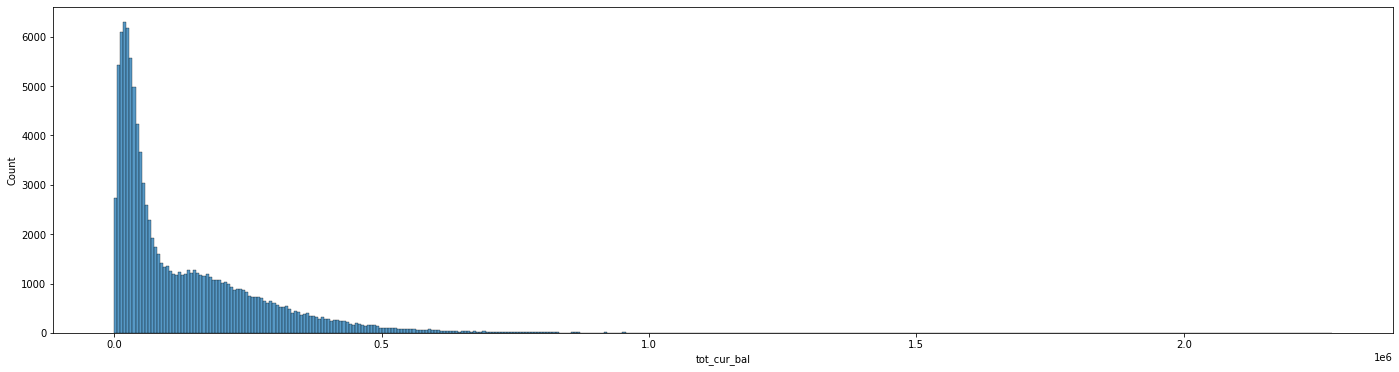

In [140]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='tot_cur_bal', bins=400, palette='viridis');

Since there are some outliers, we will drop rows with customers with 'tot_cur_bal' > $1000000.

In [141]:
df = df[df['tot_cur_bal'] < 1000001]

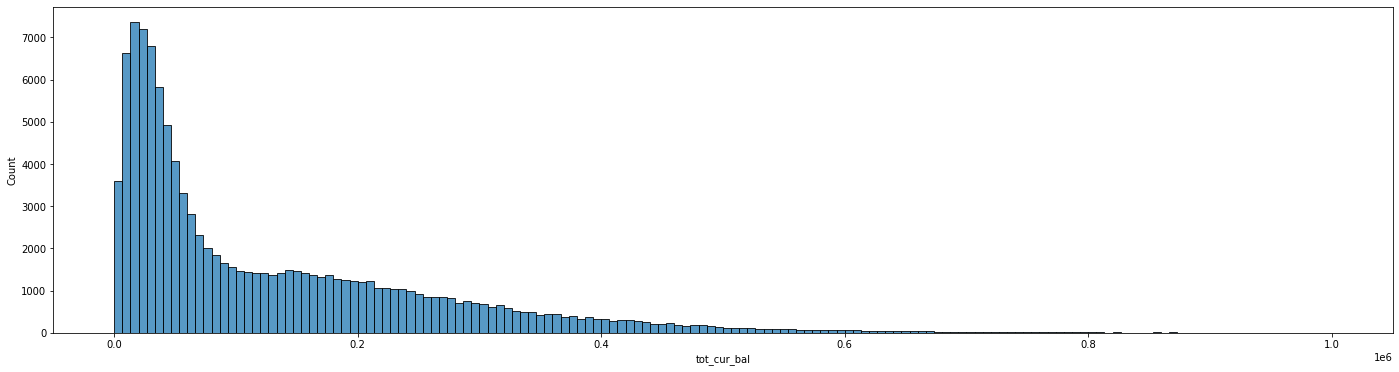

In [142]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='tot_cur_bal', bins=150, palette='viridis');

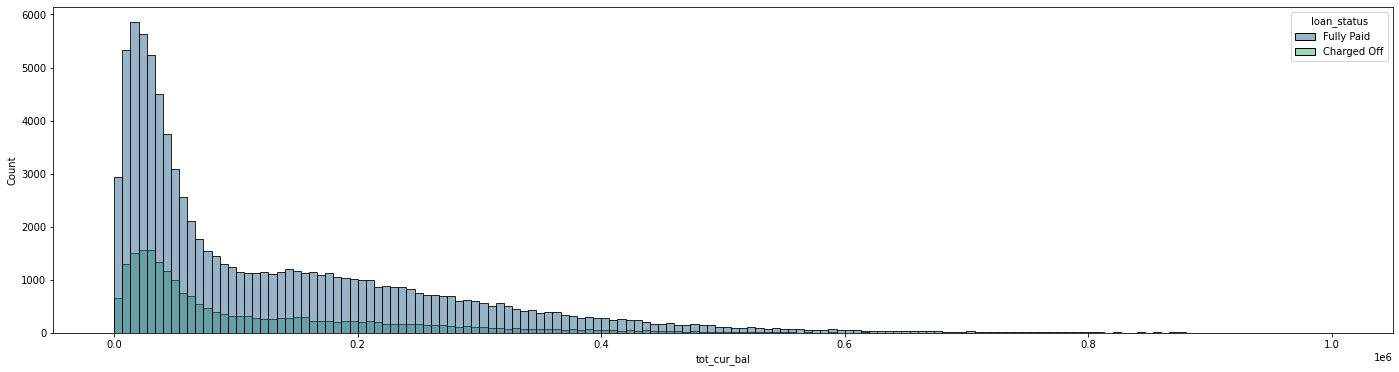

In [143]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='tot_cur_bal', bins=150, hue='loan_status', palette='viridis');

In [144]:
df.groupby('loan_status')['tot_cur_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21854.0,113290.620710,122121.084958,0.0,28600.75,60860.5,165120.75,977415.0
Fully Paid,87964.0,135521.385192,140821.924698,0.0,29351.00,78588.0,205861.00,999950.0


Mean 'tot_cur_bal' is higher in case of customers who fully paid the loan.

## 4.17 open_acc
<a id="4.17"></a>

The number of open credit lines in the borrower's credit file.

In [145]:
if_null_values('open_acc')

'No missing values'

Let's plot the distribution of 'open_acc' of customers.

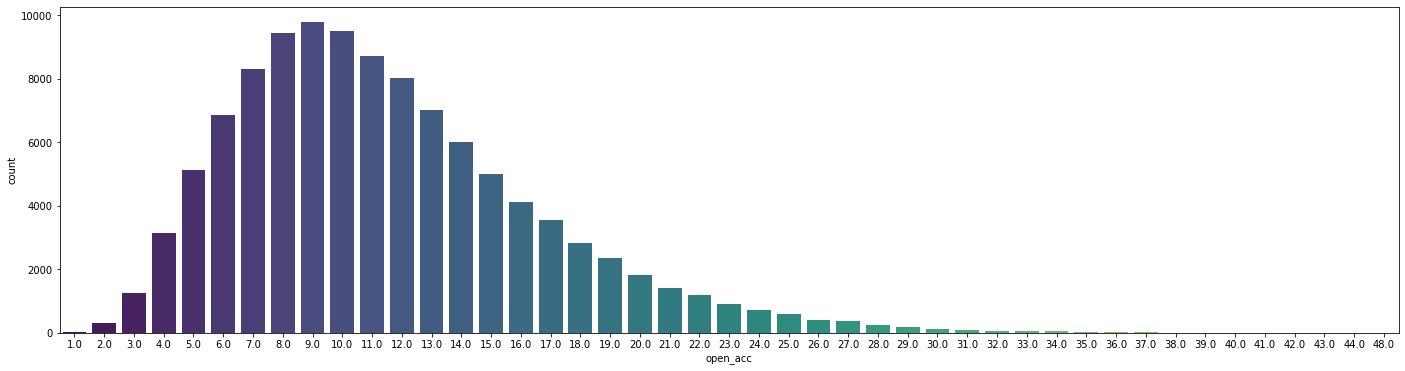

In [146]:
plt.figure(figsize=(24,6))
sns.countplot(data=df, x='open_acc', palette='viridis');

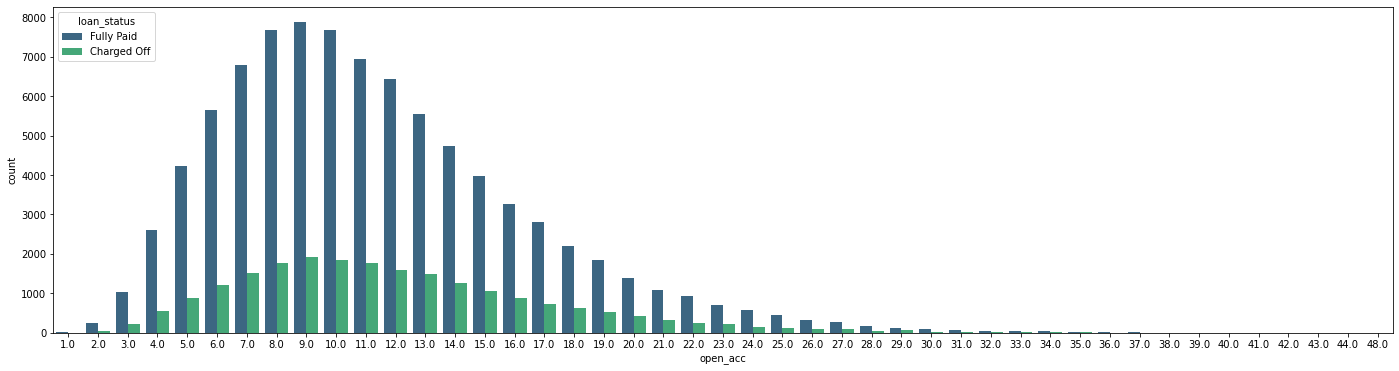

In [147]:
plt.figure(figsize=(24,6))
sns.countplot(data=df, x='open_acc', hue='loan_status', palette='viridis');

In [148]:
df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21854.0,11.913975,5.336686,1.0,8.0,11.0,15.0,44.0
Fully Paid,87964.0,11.386192,5.127906,1.0,8.0,11.0,14.0,48.0


Minute difference can be seen in the mean 'open_acc' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.18 pub_rec
<a id="4.18"></a>

Number of derogatory public records.

In [149]:
if_null_values('pub_rec')

'No missing values'

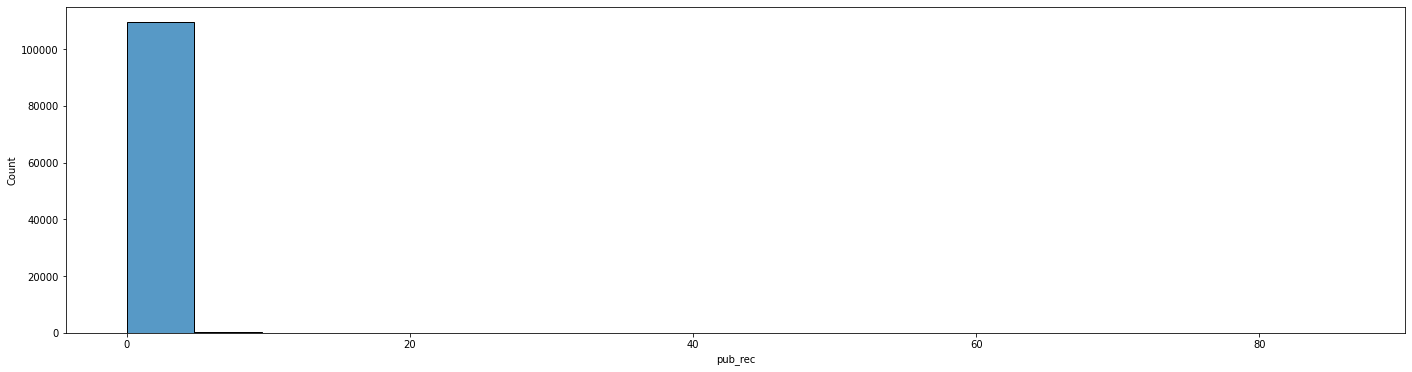

In [150]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='pub_rec', palette='viridis');

There are some outliers. Let's drop the rows with customers who have 'pub_rec > 2.

In [151]:
len(df[df['pub_rec'] > 2])*100/len(df)

1.2247536833670254

In [152]:
df = df[df['pub_rec'] < 3]

In [153]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21537.0,0.228258,0.477964,0.0,0.0,0.0,0.0,2.0
Fully Paid,86936.0,0.190600,0.446348,0.0,0.0,0.0,0.0,2.0


Minute difference can be seen in the mean 'pub_rec' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.19 pub_rec_bankruptcies
<a id="4.19"></a>

Number of public record bankruptcies.

In [154]:
if_null_values('pub_rec_bankruptcies')

'% of missing values = 0.0'

Let's calculate the correlation of 'pub_rec_bankruptcies' with other continuous features.

In [155]:
abs(df.corr()['pub_rec_bankruptcies']).sort_values(ascending=False)[1:5]

pub_rec        0.774973
fico           0.224824
revol_bal      0.145232
tot_cur_bal    0.109866
Name: pub_rec_bankruptcies, dtype: float64

Let's fill na values with mode of corresponding annual_inc values.

We will create a function to categorise 'annual_inc' in 5 categories and based on these categories, we will fill in the missing values of 'pub_rec_bankruptcies' by a group_by call.

In [156]:
def inc_cat(income):
    if income < 50000:
        return('cat 1')
    if income >= 50000 and income <100000:
        return('cat 2')
    if income >= 100000 and income <150000:
        return('cat 3')
    if income >= 150000 and income <200000:
        return('cat 4')
    if income >= 200000:
        return('cat 5')

df['annual_inc_categorised'] = df['annual_inc'].apply(inc_cat) # make a new column in the df for categorised income

Let's check if that worked.

In [157]:
df[['annual_inc_categorised', 'annual_inc']]

,annual_inc_categorised,annual_inc
0,cat 2,55000.0
1,cat 2,65000.0
2,cat 2,63000.0
4,cat 3,104433.0
5,cat 1,34000.0
...,...,...
130765,cat 2,74000.0
130766,cat 2,54000.0
130767,cat 1,40000.0
130768,cat 3,102000.0


Let us now fill in the missing value by the mean value of 'pub_rec_bankruptcies' for the corresponding 'annual_inc_categorised' column.

In [158]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(df.groupby('annual_inc_categorised')['pub_rec_bankruptcies'].transform('mean'))

In [159]:
df['pub_rec_bankruptcies'].isnull().sum()

0

Let's now drop the 'annual_inc_categorised' feature.

In [160]:
df = df.drop('annual_inc_categorised', axis=1)

In [161]:
df.groupby('loan_status')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21537.0,0.150578,0.377602,0.0,0.0,0.0,0.0,2.0
Fully Paid,86936.0,0.125737,0.351591,0.0,0.0,0.0,0.0,2.0


Minute difference can be seen in the mean 'pub_rec' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.20 purpose
<a id="4.20"></a>

A category provided by the borrower for the loan request.

In [162]:
if_null_values('purpose')

'No missing values'

In [163]:
len(df['purpose'].unique())

12

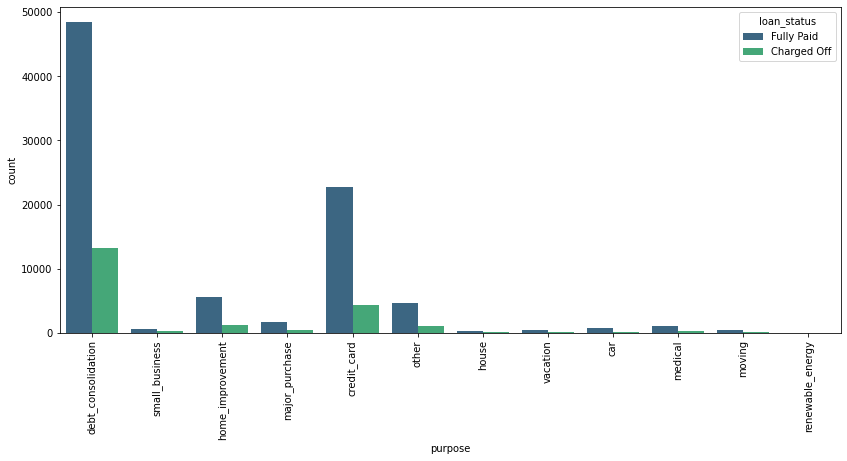

In [164]:
plt.figure(figsize=(14,6))
sns.countplot(data=df,x='purpose', hue='loan_status', palette='viridis');
plt.xticks(rotation=90);

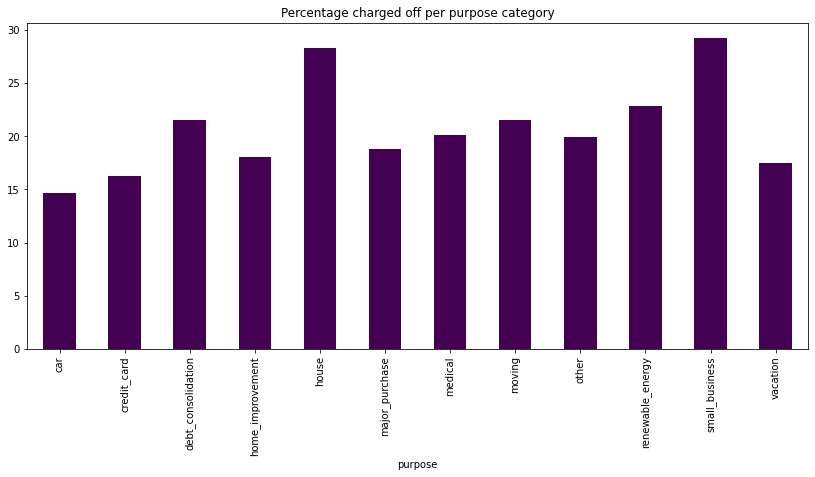

In [165]:
plt.figure(figsize=(14,6))
charged_off = df[df['loan_status']=="Charged Off"].groupby("purpose").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("purpose").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per purpose category");

Let's create dummy variables for these.

In [166]:
dummies_purpose = pd.get_dummies(df['purpose'], drop_first=True)

In [167]:
df = pd.concat([df.drop('purpose', axis=1), dummies_purpose], axis=1)

In [168]:
df.shape

(108473, 115)

## 4.21 term
<a id="4.21"></a>

The number of payments on the loan. Values are in months and can be either 36 or 60.

In [169]:
if_null_values('term')

'No missing values'

In [170]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

Let's convert these strings to integers.

In [171]:
df['term'] = df['term'].apply(lambda x: int(x[0:3]))

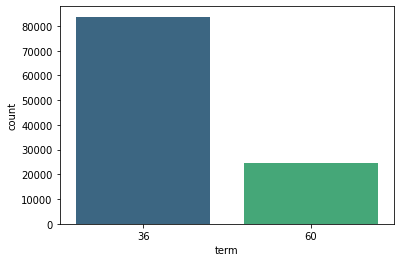

In [172]:
sns.countplot(data=df, x='term', palette='viridis')

We will convert the feature into dummies.

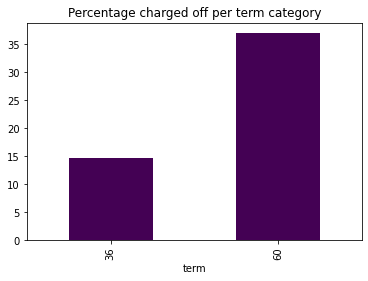

In [173]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("term").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("term").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per term category");

Customers whose loan term was 60 months had almost double chance of charging off.

In [174]:
dummies_term = pd.get_dummies(df['term'], drop_first=True)

In [175]:
pd.concat([df.drop('term', axis=1), dummies_term], axis=1)

,annual_inc,earliest_cr_line,int_rate,loan_amnt,num_actv_bc_tl,loan_status,mort_acc,tot_cur_bal,open_acc,pub_rec,...,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,60
0,55000.0,2003,13.99,3600.0,2.0,Fully Paid,1.0,144904.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,65000.0,1999,11.99,24700.0,5.0,Fully Paid,4.0,204396.0,22.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,63000.0,2000,10.78,20000.0,2.0,Fully Paid,5.0,189699.0,6.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,104433.0,1998,22.45,10400.0,4.0,Fully Paid,6.0,331730.0,12.0,0.0,...,0,0,1,0,0,0,0,0,0,1
5,34000.0,1987,13.44,11950.0,2.0,Fully Paid,0.0,12798.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130765,74000.0,2009,13.33,11000.0,5.0,Fully Paid,1.0,365496.0,16.0,0.0,...,0,0,0,0,0,0,0,0,0,1
130766,54000.0,2001,6.24,13200.0,6.0,Fully Paid,0.0,26013.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
130767,40000.0,2010,13.33,4800.0,2.0,Charged Off,0.0,8594.0,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
130768,102000.0,1996,8.18,30000.0,6.0,Fully Paid,2.0,163521.0,19.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## 4.22 title
<a id="4.22"></a>

The loan title provided by the borrower.

In [176]:
if_null_values('title')

'% of missing values = 0.1'

In [177]:
len(df['title'].unique())

15

In [178]:
df['title'].head(10)

0          Debt consolidation
1                    Business
2                         NaN
4              Major purchase
5          Debt consolidation
6          Debt consolidation
7              Major purchase
8     Credit card refinancing
9     Credit card refinancing
12                        NaN
Name: title, dtype: object

This feature has a lot of unique values for dummies. Plus this info and the info in feature purpose is closely matching. Lets drop this feature.

In [179]:
df = df.drop('title', axis=1)

In [180]:
df.shape

(108473, 114)

## 4.23 revol_bal
<a id="4.23"></a>

Total credit revolving balance.

In [181]:
if_null_values('revol_bal')

'No missing values'

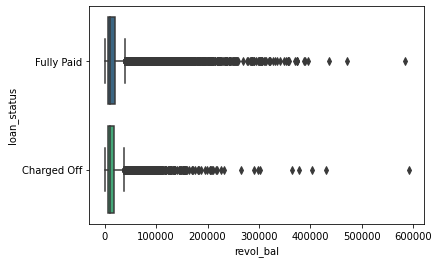

In [182]:
sns.boxplot(data=df, y='loan_status', x='revol_bal', palette='viridis')

There are some outliers. Let's first check how many rows are there with 'revol_bal' > $100000.

In [183]:
len(df[df['revol_bal'] > 100000])

879

What percentage of total rows is 8098?

In [184]:
len(df[df['revol_bal'] > 100000]) * 100 / len(df)

0.8103399002516756

It's just 0.64%, let's just drop these

In [185]:
df = df[df['revol_bal'] < 100001]

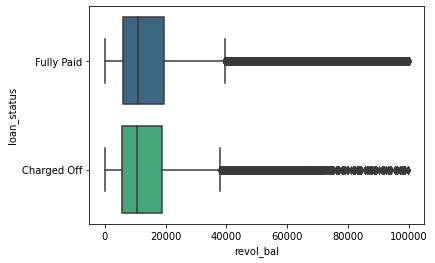

In [186]:
sns.boxplot(data=df, y='loan_status', x='revol_bal', palette='viridis');

There are still some outliers but that's okay because we can't drop a good percentage of rows.

In [187]:
df.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21432.0,14236.491881,12530.964538,0.0,5812.0,10768.5,18668.25,99701.0
Fully Paid,86162.0,14874.073501,13388.407123,0.0,5947.0,10970.0,19379.00,99964.0


Difference can be seen in the mean 'revol_bal' between the two 'loan_status' categories. We will go ahead and keep this feature.

## 4.24 revol_util
<a id="4.24"></a>

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [188]:
if_null_values('revol_util')

'% of missing values = 0.04'

Let's fill in the missing values with the mean of non missing values in 'revol_util'.

In [189]:
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

In [190]:
df['revol_util'].isnull().sum()

0

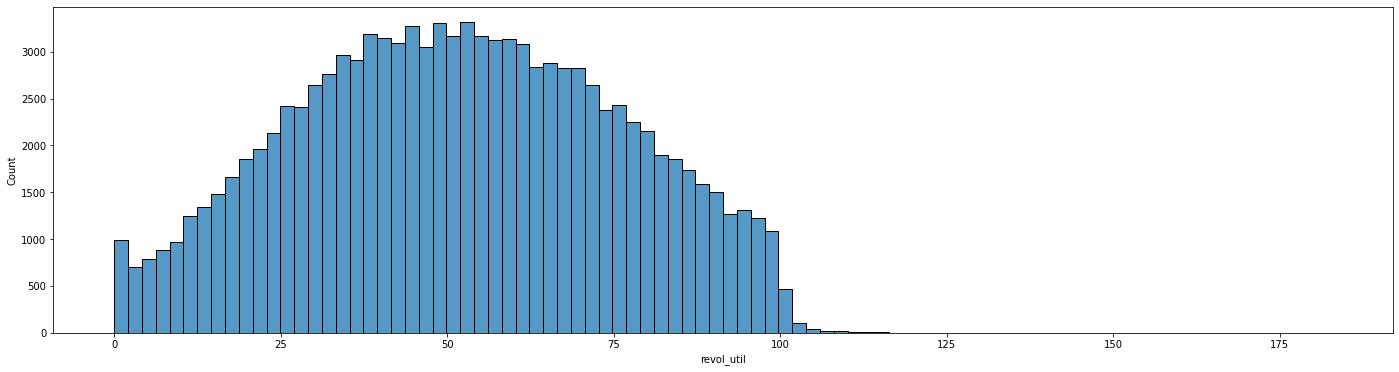

In [191]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='revol_util', bins=88, palette='viridis');

There are some outliers. Let's drop them.

In [192]:
df = df[df['revol_util'] < 150]

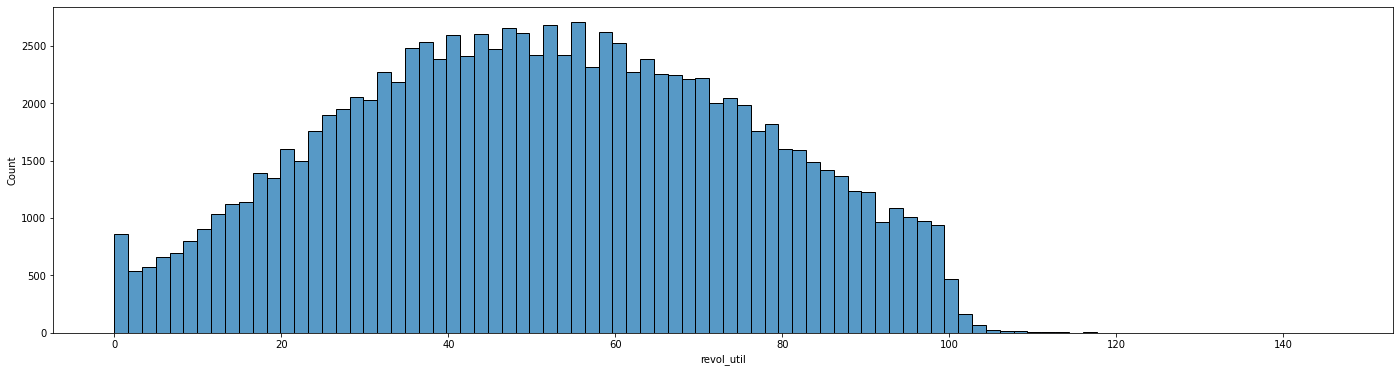

In [193]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='revol_util', bins=88, palette='viridis');

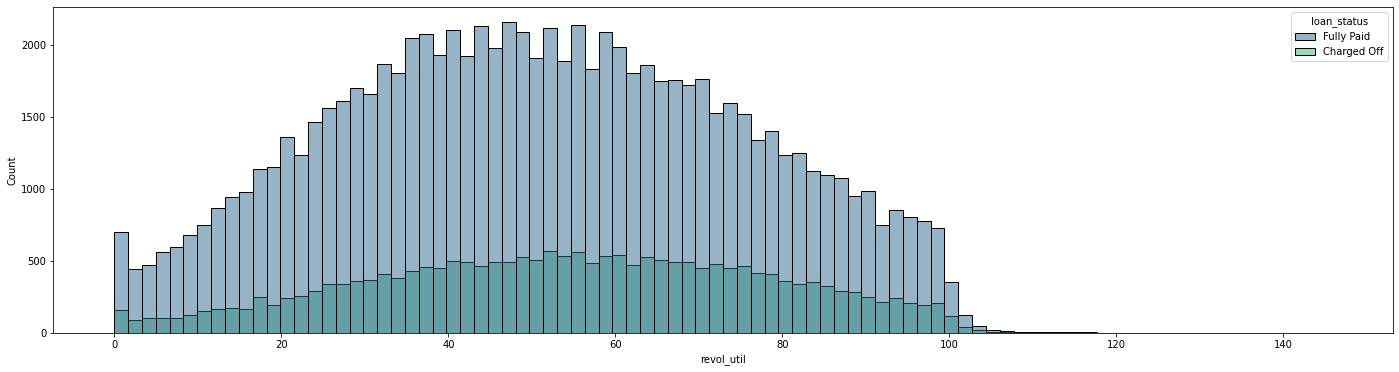

In [194]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='revol_util', bins=88, hue='loan_status', palette='viridis');

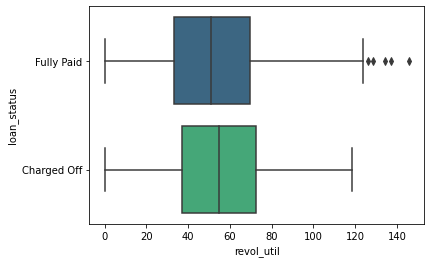

In [195]:
sns.boxplot(data=df, y='loan_status', x='revol_util', palette='viridis')

In [196]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,21431.0,54.327608,23.651927,0.0,37.0,54.7,72.3,118.6
Fully Paid,86161.0,51.138522,24.103380,0.0,33.0,50.7,69.4,145.8


Difference can be seen in the mean 'revol_util' between the two 'loan_status' categories.

## 4.25 verification_status
<a id="4.25"></a>

Indicates if income was verified by LC, not verified, or if the income source was verified.

In [197]:
if_null_values('verification_status')

'No missing values'

In [198]:
df['verification_status'].value_counts()

Source Verified    46067
Verified           34525
Not Verified       27000
Name: verification_status, dtype: int64

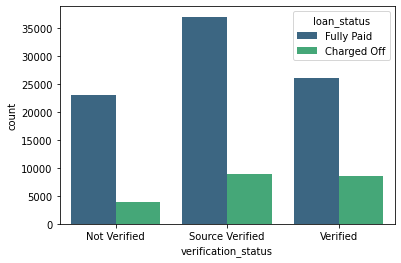

In [199]:
sns.countplot(data=df, x='verification_status', hue='loan_status', palette='viridis');

Let's check percentage charged off per initial_list_status category.

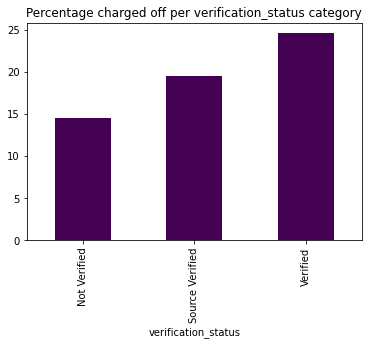

In [200]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("verification_status").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("verification_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per verification_status category");

Difference can be seen betweeen percentage charged off per 'initial_list_status' categories.

Let's create dummy variables for this feature.

In [201]:

dummies_verification_status = pd.get_dummies(df['verification_status'], drop_first=True)
df = pd.concat([df.drop('verification_status', axis=1), dummies_verification_status], axis=1)

All features are done, except the feature we want to predict. Let us map the contents in the feature, i.e., 'Fully Paid' and 'Charged Off' to boolean values.

In [202]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [203]:
df['loan_status']

0         1
1         1
2         1
4         1
5         1
         ..
130765    1
130766    1
130767    0
130768    1
130769    1
Name: loan_status, Length: 107592, dtype: int64

In [204]:
df.dtypes.value_counts()

uint8      99
float64    13
int64       3
dtype: int64

In [205]:
df.to_csv("data.csv")

# 5. Scaling and Test Train split
<a id="5"></a>

In [206]:
df.shape 

(107592, 115)

In [207]:
X = df.drop('loan_status', axis=1)

In [208]:
y = df['loan_status']

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Scaling

In [211]:
from sklearn.preprocessing import MinMaxScaler

In [212]:
scaler = MinMaxScaler()

In [213]:
X_train = scaler.fit_transform(X_train)

In [214]:
X_test = scaler.transform(X_test)

In [216]:
print(oooo)

NameError: ignored

# 6. Creating Models
<a id="6"></a>

In [ ]:
algorithm = []
accuracies_list = []
precision_list = []
Recall_list = []
confusion_metrix_list = []

## 6.1 XGBoost
<a id="6.1"></a>

In [217]:
# conda install xgboost

In [218]:
from xgboost import XGBClassifier

In [219]:
# fit model to training data
modelx = XGBClassifier()
modelx.fit(X_train, y_train)

XGBClassifier()

In [220]:
preds_xgboost = modelx.predict(X_test) 

In [221]:
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report

In [222]:
classification_report_xgboost = classification_report(y_test,preds_xgboost)
print(classification_report_xgboost)

              precision    recall  f1-score   support

           0       0.56      0.12      0.20      6347
           1       0.82      0.98      0.89     25931

    accuracy                           0.81     32278
   macro avg       0.69      0.55      0.55     32278
weighted avg       0.77      0.81      0.76     32278



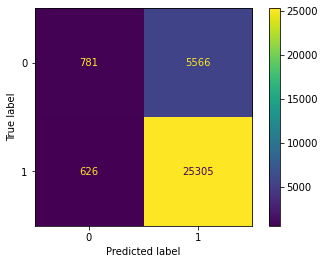

In [223]:
plot_confusion_matrix(modelx,X_test,y_test)

In [224]:
from sklearn import metrics
accuracyXGBoots = accuracy_score(y_test, preds_xgboost)*100
print(accuracyXGBoots)

80.81665530702026


## 6.2 Random Forests
<a id="6.2"></a>

In [225]:
from sklearn.ensemble import RandomForestClassifier

In [226]:
rf = RandomForestClassifier(n_estimators=100)

In [227]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [228]:
predsRandom = rf.predict(X_test)

In [229]:
classification_report_random = classification_report(y_test,predsRandom)
print(classification_report_random)

              precision    recall  f1-score   support

           0       0.56      0.13      0.20      6347
           1       0.82      0.98      0.89     25931

    accuracy                           0.81     32278
   macro avg       0.69      0.55      0.55     32278
weighted avg       0.77      0.81      0.76     32278



In [264]:
type(classification_report_random)

str

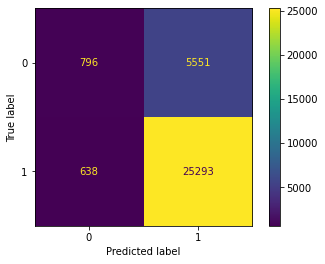

In [230]:
plot_confusion_matrix(rf,X_test,y_test)

In [231]:
# Calculate the absolute errors
accuracyRandomForest = accuracy_score(y_test, predsRandom)*100
print(accuracyRandomForest)

80.82594956316996


## 6.3 ANN
<a id="6.3"></a>

In [232]:
# pip install tensorflow

In [233]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [234]:
model = Sequential()

# input layer
model.add(Dense(119,  activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

# With GPUs, Kaggle provides 13 GB of RAM whereas using only the CPU, we get 16 Gb of RAM. Somehow 13 Gb is just not sufficient here. With GPU, it takes around 14 sec for each epoch.
# So I am using just CPU for ANN as well. The below error is probably due to that. 

In [235]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=10,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Epoch 1/10
295/295 [==============================] - 4s 8ms/step - loss: 0.4677 - val_loss: 0.4430
Epoch 2/10
295/295 [==============================] - 3s 9ms/step - loss: 0.4496 - val_loss: 0.4391
Epoch 3/10
295/295 [==============================] - 2s 8ms/step - loss: 0.4459 - val_loss: 0.4394
Epoch 4/10
295/295 [==============================] - 3s 10ms/step - loss: 0.4428 - val_loss: 0.4385
Epoch 5/10
295/295 [==============================] - 2s 8ms/step - loss: 0.4405 - val_loss: 0.4396
Epoch 6/10
295/295 [==============================] - 3s 9ms/step - loss: 0.4389 - val_loss: 0.4387
Epoch 7/10
295/295 [==============================] - 2s 8ms/step - loss: 0.4358 - val_loss: 0.4392
Epoch 8/10
295/295 [==============================] - 3s 9ms/step - loss: 0.4341 - val_loss: 0.4401
Epoch 9/10
295/295 [==============================] - 3s 9ms/step - loss: 0.4315 - val_loss: 0.4413
Epoch 10/10
295/295 [==============================] - 2s 8ms/step - loss: 0.4301 - val_loss: 0.443

In [236]:
losses = pd.DataFrame(model.history.history)

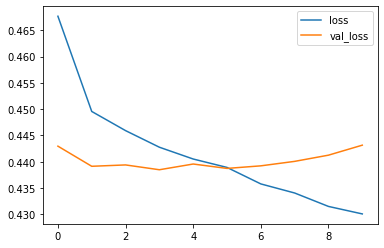

In [237]:
losses[['loss','val_loss']].plot()

In [238]:
from sklearn.metrics import classification_report,confusion_matrix

In [239]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
classification_report_5 = classification_report(y_test,predictions)
print(classification_report_5)

1009/1009 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.19      0.27      6347
           1       0.83      0.95      0.89     25931

    accuracy                           0.80     32278
   macro avg       0.67      0.57      0.58     32278
weighted avg       0.76      0.80      0.77     32278



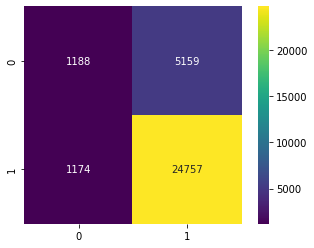

In [240]:
from sklearn.metrics import ConfusionMatrixDisplay , roc_auc_score

cm = confusion_matrix(y_test,predictions)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', square=True) #plot_confusion_matrix does not work directly for ANN

In [241]:
predictions = (model.predict(X_test) > 0.7).astype("int32")
classification_report_7 = classification_report(y_test,predictions)
print(classification_report_7)


1009/1009 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.41      0.45      0.43      6347
           1       0.86      0.84      0.85     25931

    accuracy                           0.76     32278
   macro avg       0.63      0.64      0.64     32278
weighted avg       0.77      0.76      0.77     32278



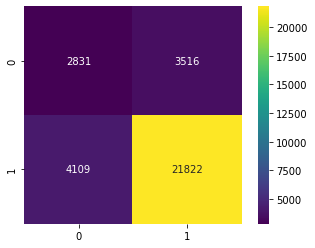

In [242]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test,predictions)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', square=True) #plot_confusion_matrix does not work directly for ANN

## MultiLinear Regression

In [243]:
# print(X_test);

In [244]:
from sklearn.linear_model import LinearRegression  
regressor= LinearRegression()  
regressor.fit(X_train,y_train)

#Predicting the Test set result;  
y_pred_multilinear= regressor.predict(X_test)

In [245]:
from sklearn.metrics import r2_score
# print('Train Score: ', regressor.score(X_train, y_train))
# print('Test Score: ', regressor.score(X_test, y_pred_multilinear))
# score_regressor_score = regressor.score(X_test, y_pred_multilinear)
# accuracy_linearReg = accuracy_score(y_test,y_pred_multilinear)*100
accuracy_linearReg = r2_score(y_test, y_pred_multilinear)*100
print(accuracy_linearReg)

11.718654474366696


## svm

In [246]:
# from sklearn.svm import SVC # "Support vector classifier"
# classifier_svm = SVC(kernel='linear', random_state=0)
# classifier_svm.fit(X_train, y_train)
# #Predicting the test set result
# y_pred_svm= classifier_svm.predict(X_test)


In [247]:
# cm= confusion_matrix(y_test, y_pred_svm) 

In [248]:
# classification_report_svm = classification_report(y_test,y_pred_svm)
# print(classification_report_svm)

In [249]:
# f = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', square=True)

In [250]:
# accuracy_svm = accuracy_score(y_test,y_pred_svm)*100

# Logistic Regrassion

In [251]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred_logistic = classifier.predict(X_test)

In [252]:
cm = confusion_matrix(y_test, y_pred_logistic)
print ("Confusion Matrix : \n", cm)
classification_report_log_reg = classification_report(y_test,y_pred_logistic)

Confusion Matrix : 
 [[  843  5504]
 [  666 25265]]


In [253]:
print(classification_report_log_reg)

              precision    recall  f1-score   support

           0       0.56      0.13      0.21      6347
           1       0.82      0.97      0.89     25931

    accuracy                           0.81     32278
   macro avg       0.69      0.55      0.55     32278
weighted avg       0.77      0.81      0.76     32278



In [254]:
from sklearn.metrics import accuracy_score
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print ("Accuracy : ", accuracy_logistic)

Accuracy :  0.8088481318545139


# KNN

In [255]:
from sklearn.neighbors import KNeighborsClassifier
# neighbors = np.arange(1, 9)
# train_accuracy = np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))
  
# # Loop over K values
# for i, k in enumerate(neighbors):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train, y_train)
      
#     # Compute training and test data accuracy
#     train_accuracy[i] = knn.score(X_train, y_train)
#     test_accuracy[i] = knn.score(X_test, y_test)
  
# # Generate plot
# plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
# plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
# plt.legend()
# plt.xlabel('n_neighbors')
# plt.ylabel('Accuracy')
# plt.show()

In [256]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [257]:
y_pred_knn = knn.predict(X_test)

In [258]:
knn_accuracy = knn.score(X_test, y_test)
print(knn_accuracy)

0.7900737344321209


In [259]:
cm = confusion_matrix(y_test, y_pred_logistic)
print ("Confusion Matrix : \n", cm)
classification_report_log_reg = classification_report(y_test,y_pred_logistic)

Confusion Matrix : 
 [[  843  5504]
 [  666 25265]]


# 7. Conclusion
<a id="7"></a>

The question arises, what are we actually trying to predict?<br>
Being in the shoes of a data scientist of a loan proider company, my aim, in the given scenario would be to predict as accurately as possible the customers whose loan was charged off, i.e., they were not able to fully pay their loan. We might be able to predict the cases where a customer won't pay back the loan amount but that will also result in cases where the model predicts that a customer will not pay back the loan amount but in reality, the customer will. This way, the company will lose potential customers.<br>
So, there is always a trade-off. We need to step back and question, whatare we trying to do and what work has already been done? <br>
The current model, far from perfect, was an attempt to build a prototype to predict the customers who will fully pay or would not be able to payback the amount. Although, there is a scope of improvement by considering more features and test out different paramenters for different models. I was reaching the permissible RAM limits in my notebook, hence I was not able to thoroughly test out different parameters and more models.<br>
Any suggestions to improve the notebook are welcome!

In [260]:
from sklearn.metrics import  roc_auc_score

In [261]:
ann_accuracy = roc_auc_score(y_test, model.predict(X_test))*100

1009/1009 [==============================] - 3s 3ms/step


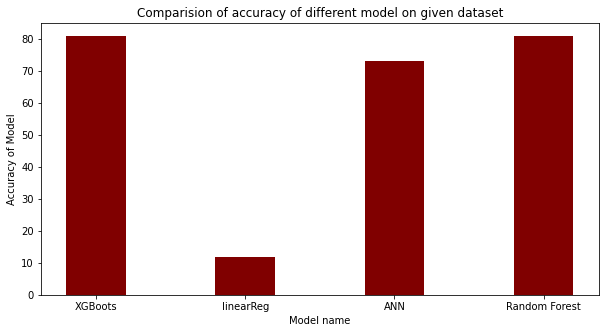

In [262]:
import numpy as np
import matplotlib.pyplot as plt
 
# model_accuracy_list = [round(80.41055749275301, 2), round(8.687333831051525, 2), round(71.2635124424338, 2), round(80.26876864260808, 2)]
model_accuracy_list = [round(accuracyXGBoots, 2) , round(accuracy_linearReg, 2), round(ann_accuracy, 2), round(accuracyRandomForest, 2)]
model_name = ["XGBoots","linearReg", "ANN", "Random Forest" ]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(model_name, model_accuracy_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model name")
plt.ylabel("Accuracy of Model")
plt.title("Comparision of accuracy of different model on given dataset")
plt.show()